# Discrete Event Simulation: Dining Philosophers



**Task overview**
- 5 philosophers sitting around round table
- 5 chopsticks (one between each pair of philosophers)
- Each philosopher needs 2 chopsticks to eat
- States: Thinking -> Hungry -> Eating -> Thinking

**Tasks implemented:**
1. Basic simulation (100 time units)
2. Deadlock detection
3. Deadlock prevention (priority ordering + timeout strategies)

In [1]:
import heapq
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
from enum import Enum
from collections import deque

from copy import deepcopy

random.seed(54)
np.random.seed(54)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Core Classes and Data Structures

In [2]:
class PhilosopherState(Enum):
    """States philosopher can be in"""
    THINKING = "thinking"
    HUNGRY = "hungry"
    EATING = "eating"


class EventType(Enum):
    """Types of events in the simulation"""
    FINISH_THINKING = "finish_thinking"
    TRY_ACQUIRE_CHOPSTICKS = "try_acquire_chopsticks"
    FINISH_EATING = "finish_eating"
    TIMEOUT_RELEASE = "timeout_release"
    DELAYED_RELEASE = "delayed_release"


@dataclass(order=True)
class Event:
    """Event in the discrete event simulation"""
    time: float
    event_type: EventType = field(compare=False)
    philosopher_id: int = field(compare=False)
    generation: int = field(compare=False, default=0)


class Chopstick:
    """Represents a chopstick resource"""
    def __init__(self, id: int):
        self.id = id
        self.held_by: Optional[int] = None

    def is_available(self) -> bool:
        return self.held_by is None

    def acquire(self, philosopher_id: int) -> bool:
        if self.is_available():
            self.held_by = philosopher_id
            return True
        return False

    def release(self):
        self.held_by = None


class Philosopher:
    """Represents a philosopher with state and behavior"""
    def __init__(self, id: int, left: int, right: int, deadlock_prone: bool = False, 
                 unif_thinking_time: bool = False, think_unif_low: float = 2.0, think_unif_high: float = 30.0,
                 gauss_eating_time: bool = False, eat_mean: float = 5.0, eat_sigma: float = 1.0, eat_gauss_low: float = 1.0, eat_gauss_high: float = 10.0):
        self.id = id
        self.state = PhilosopherState.THINKING
        self.left_chopstick_id = left
        self.right_chopstick_id = right
        self.held_chopsticks: List[int] = []
        self.eat_count = 0
        self.total_thinking_time = 0.0
        self.total_eating_time = 0.0
        self.total_hungry_time = 0.0
        self.last_state_change = 0.0
        self.last_ate_time = 0.0
        self.attempt_start_time = None
        self.generation = 0
        self.deadlock_prone = deadlock_prone

        ## for task 5 ##
        self.unif_thinking_time = unif_thinking_time
        self.think_unif_low = think_unif_low
        self.think_unif_high = think_unif_high

        self.gauss_eating_time = gauss_eating_time
        self.eat_mean = eat_mean
        self.eat_sigma = eat_sigma
        self.eat_gauss_low = eat_gauss_low
        self.eat_gauss_high = eat_gauss_high

        # for selfish philosophers: ignore timeout release rule
        self.ignore_timeout = False     

        # for selfish philosophers: ignore priority ordering -> random ordering of which chopstick to use
        self.random_order = False

        # for selfish philosophers: wait a while before dropping chopsticks after eating
        self.post_eat_hold = 0.0
       


    def get_thinking_time(self):
        # return 0.0 if self.deadlock_prone else random.expovariate(1 / 5)
        if self.deadlock_prone:
            return 0.0
        if self.unif_thinking_time:
            return random.uniform(self.think_unif_low, self.think_unif_high)
        return random.expovariate(1 / 5)

    def get_eating_time(self):
        def truncated_normal() -> float:
            """Sample N(mu, sigma) but reject values outside [lo, hi]."""
            mu = self.eat_mean
            sigma = self.eat_sigma
            lo = self.eat_gauss_low
            hi = self.eat_gauss_high

            
            if self.eat_sigma <= 0:
                return max(lo, min(hi, mu))
            while True:
                x = random.gauss(mu, sigma)
                if lo <= x <= hi:
                    return x
                
        # return random.uniform(0.3, 0.8) if self.deadlock_prone else random.expovariate(1 / 3)
        if self.deadlock_prone:
            return random.uniform(0.3, 0.8)
        if self.gauss_eating_time:
            return truncated_normal()
        return random.expovariate(1 / 3)

    def get_retry_time(self):
        return 0.2 if self.deadlock_prone else random.uniform(0.1, 0.5)#+ random.uniform(0, 1e-6)

    def update_state_time(self, now):
        dt = now - self.last_state_change
        if self.state == PhilosopherState.THINKING:
            self.total_thinking_time += dt
        elif self.state == PhilosopherState.HUNGRY:
            self.total_hungry_time += dt
        elif self.state == PhilosopherState.EATING:
            self.total_eating_time += dt
        self.last_state_change = now

## Simulation Engine

In [3]:
class DiningPhilosophersSimulation:
    """Discrete event simulation of dining philosophers"""

    def __init__(
        self,
        num_philosophers: int = 5,
        deadlock_detection: bool = False,
        prevention_strategy: str = "none",
        starvation_prevention: bool = False,
        timeout_duration: float = 2.0,
        deadlock_prone: bool = False,
        synchronized_start: bool = False,
        force_deadlock_demo: bool = False,
        halt_on_deadlock: bool = False,
        # rest of options is for task 5:
        unif_thinking_time: bool = False,
        think_unif_low: float = 2.0,
        think_unif_high: float = 30.0,
        gauss_eating_time: bool = False,
        eat_mean: float = 5.0,
        eat_sigma: float = 1.0,
        eat_gauss_low: float = 1.0,
        eat_gauss_high: float = 10.0,
        selfish_ids: set = None,
        conspiracy_ids: set = None,
        conspiracy_victim: Optional[int] = None,
        conspiracy_extra_hold: float = 1.0,
        conspiracy_retry_fast: float = 0.02
    ):
        """
        Initialize simulation

        Args:
            num_philosophers: number of philosophers (by default 5)
            deadlock_detection: enable deadlock detection
            prevention_strategy: 'none', 'priority', 'timeout'
            timeout_duration: timeout for releasing chopsticks
            deadlock_prone: use tighter think/eat times to increase contention
            synchronized_start: have all philosophers start hungry at t=0 (for detection demo)
            force_deadlock_demo: force everyone to hold left chopstick at t=0 (demo only)
            halt_on_deadlock: if True, stop simulation on first deadlock (default: False)
        """
        self.num_philosophers = num_philosophers
        self.current_time = 0.0
        self.event_queue = []
        self.deadlock_detection = deadlock_detection
        self.prevention_strategy = prevention_strategy
        self.starvation_prevention = starvation_prevention
        self.timeout_duration = timeout_duration
        self.deadlock_prone = deadlock_prone
        self.synchronized_start = synchronized_start
        self.force_deadlock_demo = force_deadlock_demo
        self.in_deadlock = False       # latch to avoid multiple counts per deadlock
        self.halt_on_deadlock = halt_on_deadlock
        self.halted = False            # track if simulation was halted

        self.timeout_release_count = 0  # counts how often timeout release was triggered
        # self.timeout_release_count = 0 if prevention_strategy == "timeout" else None

        # queues for starvation prevention
        self.hungry_queue = deque()
        self.in_queue = set()

        # stats
        self.deadlock_count = 0
        self.deadlock_times = []

        # persistent deadlock tracking (for timeout evaluation)
        self.progress_time = 0.0
        self.deadlock_active = False
        self.deadlock_start_time = None
        self.persistent_deadlock_count = 0
        self.persistent_deadlock_times = []
        self.persistent_deadlock_window = 3.0 * self.timeout_duration
        self.persistent_deadlock_counted = False

        # for conspiracy in task 5
        self.conspiracy_ids = set(conspiracy_ids or [])
        self.conspiracy_victim = conspiracy_victim
        self.conspiracy_extra_hold = conspiracy_extra_hold
        self.conspiracy_retry_fast = conspiracy_retry_fast


        self.event_log = []

        # resources
        self.chopsticks = [Chopstick(i) for i in range(num_philosophers)]

        # philosophers
        # stores id's of selfish philosophers
        self.selfish_ids = set(selfish_ids or [])

        self.philosophers = []
        for i in range(num_philosophers):
            left = i
            right = (i + 1) % num_philosophers
            self.philosophers.append(
                Philosopher(
                    i, left, right, deadlock_prone,
                    unif_thinking_time, think_unif_low, think_unif_high,
                    gauss_eating_time, eat_mean, eat_sigma, eat_gauss_low, eat_gauss_high
                )
            )

        # for task 5: configure selfish philosophers (only if no conspiracy)
        if not self.conspiracy_ids:
            for p in self.philosophers:
                if p.id in self.selfish_ids:
                    
                    if prevention_strategy == "timeout":
                        p.ignore_timeout = True
                    else:
                        p.random_order = True

                    p.post_eat_hold = 1.0   

        if synchronized_start:
            # everyone hungry at t=0, no chopsticks yet
            for phil in self.philosophers:
                phil.state = PhilosopherState.HUNGRY
                if self.starvation_prevention and phil.id not in self.in_queue:
                    self.hungry_queue.append(phil.id)
                    self.in_queue.add(phil.id)
                phil.last_state_change = 0.0
                self.schedule_event(Event(0.0, EventType.TRY_ACQUIRE_CHOPSTICKS, phil.id, phil.generation))
        else:
            # Normal initialization: everyone starts thinking
            for phil in self.philosophers:
                thinking_time = phil.get_thinking_time()
                self.schedule_event(Event(thinking_time, EventType.FINISH_THINKING, phil.id))

        # Optional demo: force immediate circular wait (everyone holds left)
        if force_deadlock_demo:
            for phil in self.philosophers:
                phil.state = PhilosopherState.HUNGRY
                if self.starvation_prevention and phil.id not in self.in_queue:
                    self.hungry_queue.append(phil.id)
                    self.in_queue.add(phil.id)
                phil.held_chopsticks = [phil.left_chopstick_id]
                self.chopsticks[phil.left_chopstick_id].held_by = phil.id
                phil.last_state_change = 0.0
                self.schedule_event(Event(0.0, EventType.TRY_ACQUIRE_CHOPSTICKS, phil.id, phil.generation))

    def schedule_event(self, event: Event):
        """Add event to priority queue"""
        # event.time += random.uniform(0, 1e-9)
        heapq.heappush(self.event_queue, event)

    def log_event(self, description: str):
        """Log simulation event"""
        self.event_log.append({
            'time': self.current_time,
            'description': description
        })

    def get_chopstick_order(self, philosopher: Philosopher) -> Tuple[int, int]:
        """Get chopstick acquisition order based on prevention strategy"""
        left = philosopher.left_chopstick_id
        right = philosopher.right_chopstick_id

        # selfish ignores priority: random left/right first
        if philosopher.random_order:
            return (left, right) if random.random() < 0.5 else (right, left)

        # --- CONSPIRACY: targeted blocking order (only when victim is hungry) ---
        if self.conspiracy_ids and philosopher.id in self.conspiracy_ids and self.conspiracy_active():
            v = self.conspiracy_victim
            n = self.num_philosophers

            # victim critical chopsticks: {v, v+1}
            c_left  = v
            c_right = (v + 1) % n

            # the conspirators should be the neighbors of the victim
            left_neighbor  = (v - 1) % n
            right_neighbor = (v + 1) % n

            # left neighbor blocks chopstick v, right neighbor blocks chopstick v+1
            if philosopher.id == left_neighbor:
                target = c_left
            elif philosopher.id == right_neighbor:
                target = c_right
            else:
                target = None  # conspirator not adjacent -> no targeted block

            # If the target is one of my two chopsticks, try it first
            if target is not None:
                if target == left and right != left:
                    return (left, right)
                if target == right and left != right:
                    return (right, left)
            # fall through if not applicable

        # normal behavior
        if self.prevention_strategy == "priority":
            return (min(left, right), max(left, right))

        return (left, right)

        # # normal behavior
        # if self.prevention_strategy == "priority":
        #     return (min(left, right), max(left, right))

        # return (left, right)

    def _cleanup_hungry_queue(self):
        """Remove stale IDs at the front (keeps queue usable without full rescans)."""
        while self.hungry_queue and self.philosophers[self.hungry_queue[0]].state != PhilosopherState.HUNGRY:
            pid = self.hungry_queue.popleft()
            self.in_queue.discard(pid)

    def _pick_starvation_priority(self) -> Optional[int]:
        """
        Starvation avoidance: pick the hungry philosopher with the longest
        time since last ate (current_time - last_ate_time).
        """
        if not self.hungry_queue:
            return None

        best_id = None
        best_score = None
        for pid in self.hungry_queue:
            p = self.philosophers[pid]
            if p.state != PhilosopherState.HUNGRY:
                continue
            score = self.current_time - p.last_ate_time
            if best_id is None or score > best_score or (score == best_score and pid < best_id):
                best_id = pid
                best_score = score
        return best_id

    def try_acquire_chopsticks(self, philosopher: Philosopher) -> bool:
        """Two-phase acquire: take first chopstick, then try for second later"""
        first_id, second_id = self.get_chopstick_order(philosopher)
        first_chopstick = self.chopsticks[first_id]
        second_chopstick = self.chopsticks[second_id]

        has_first = first_id in philosopher.held_chopsticks
        has_second = second_id in philosopher.held_chopsticks

        # Step 1: grab the first if not already holding it
        if not has_first:
            if first_chopstick.acquire(philosopher.id):
                philosopher.held_chopsticks.append(first_id)
            else:
                return False
            # give everyone time to grab their first chopstick
            return False

        # Step 2: try to grab the second
        if not has_second:
            if second_chopstick.acquire(philosopher.id):
                philosopher.held_chopsticks.append(second_id)
                return True
            else:
                if self.prevention_strategy == "timeout" and philosopher.attempt_start_time is None:
                    philosopher.attempt_start_time = self.current_time
                    self.schedule_event(Event(
                        self.current_time + self.timeout_duration,
                        EventType.TIMEOUT_RELEASE,
                        philosopher.id,
                        philosopher.generation
                    ))
                return False

        # Already holding both
        return True

    def release_one(self, philosopher: Philosopher, cid: int):
        if cid in philosopher.held_chopsticks:
            self.chopsticks[cid].release()
            philosopher.held_chopsticks.remove(cid)
 

    def release_chopsticks(self, philosopher: Philosopher):
        """Release all held chopsticks"""
        for chopstick_id in philosopher.held_chopsticks:
            self.chopsticks[chopstick_id].release()
        philosopher.held_chopsticks = []
        philosopher.attempt_start_time = None
        # philosopher.generation += 1  # invalidate pending events for this philosopher

    def check_deadlock(self) -> bool:
        """
        Check if system is in deadlock.
        Deadlock = all philosophers hungry AND each holds exactly one chopstick (circular wait).
        This is a structural condition — detected immediately, no time delay needed.
        """
        if not self.deadlock_detection:
            return False

        hungry_count = sum(1 for p in self.philosophers if p.state == PhilosopherState.HUNGRY)
        if hungry_count == self.num_philosophers:
            holding_one = sum(1 for p in self.philosophers if len(p.held_chopsticks) == 1)
            if holding_one == self.num_philosophers:
                return True  # circular wait confirmed
        return False

    def kick_front(self):
        if not self.starvation_prevention:
            return
        self._cleanup_hungry_queue()
        chosen_id = self._pick_starvation_priority()
        if chosen_id is None:
            return
        chosen = self.philosophers[chosen_id]
        # schedule a single immediate attempt for the chosen philosopher
        self.schedule_event(Event(self.current_time, EventType.TRY_ACQUIRE_CHOPSTICKS, chosen_id, chosen.generation))


    def handle_finish_thinking(self, philosopher: Philosopher):
        philosopher.update_state_time(self.current_time)
        philosopher.state = PhilosopherState.HUNGRY

        if self.starvation_prevention:
            if philosopher.id not in self.in_queue:
                self.hungry_queue.append(philosopher.id)
                self.in_queue.add(philosopher.id)

            self.log_event(f"Philosopher {philosopher.id} is now HUNGRY")
            self.kick_front()
            return

        self.log_event(f"Philosopher {philosopher.id} is now HUNGRY")
        self.schedule_event(Event(self.current_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))


    def handle_try_acquire(self, philosopher: Philosopher):
        if philosopher.state != PhilosopherState.HUNGRY:
            return

        success = self.try_acquire_chopsticks(philosopher)

        if success:
            philosopher.update_state_time(self.current_time)
            philosopher.state = PhilosopherState.EATING
            philosopher.attempt_start_time = None

            # progress happened (someone eats)
            self.progress_time = self.current_time

            if self.starvation_prevention and philosopher.id in self.in_queue:
                self.in_queue.discard(philosopher.id)
                try:
                    self.hungry_queue.remove(philosopher.id)
                except ValueError:
                    pass

            philosopher.eat_count += 1
            philosopher.last_ate_time = self.current_time
            self.in_deadlock = False  # clear latch on progress
            self.log_event(f"Philosopher {philosopher.id} is now EATING (count: {philosopher.eat_count})")
            eating_time = philosopher.get_eating_time()
            self.schedule_event(Event(self.current_time + eating_time, EventType.FINISH_EATING, philosopher.id, philosopher.generation))
        else:
            # retry_time = philosopher.get_retry_time()
            retry_time = philosopher.get_retry_time()
            # if philosopher.id in self.conspiracy_ids and self.conspiracy_active():
            #     retry_time = min(retry_time, self.conspiracy_retry_fast)
            # conspiracy: conspirators retry faster
            if self.conspiracy_ids and philosopher.id in self.conspiracy_ids and self.conspiracy_active():
                retry_time = min(retry_time, self.conspiracy_retry_fast)

            # conspiracy: victim retries slower (starvation pressure)
            if self.conspiracy_ids and philosopher.id == self.conspiracy_victim and self.conspiracy_active():
                retry_time = max(retry_time, 0.5) 

            self.schedule_event(Event(self.current_time + retry_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))

    def conspiracy_active(self) -> bool:
        v = self.conspiracy_victim
        return (v is not None) and (self.philosophers[v].state == PhilosopherState.HUNGRY)

    def victim_critical_chopsticks(self) -> set:
        v = self.conspiracy_victim
        if v is None:
            return set()
        return {v, (v + 1) % self.num_philosophers}


    def handle_finish_eating(self, philosopher: Philosopher):
        self.log_event(f"FINISH_EATING handled for {philosopher.id} (gen={philosopher.generation})")
        philosopher.update_state_time(self.current_time)

        philosopher.attempt_start_time = None
        
        hold = 0.0 # default

        # selfish mode only when conspiracy is inactive
        if not self.conspiracy_ids:
            hold = getattr(philosopher, "post_eat_hold", 0.0)

        if self.conspiracy_ids and philosopher.id in self.conspiracy_ids and self.conspiracy_active():
            v = self.conspiracy_victim
            n = self.num_philosophers

            left_neighbor  = (v - 1) % n
            right_neighbor = (v + 1) % n

            # target chopstick to block the victim
            if philosopher.id == left_neighbor:
                target = v                  # blocks victim's left chopstick
            elif philosopher.id == right_neighbor:
                target = (v + 1) % n        # blocks victim's right chopstick
            else:
                target = None

            if target is not None and target in philosopher.held_chopsticks:
                hold = self.conspiracy_extra_hold

                # release all other chopsticks immediately (partial release)
                for cid in philosopher.held_chopsticks.copy():
                    if cid != target:
                        self.release_one(philosopher, cid)

                self.log_event(
                    f"Conspiracy: Philosopher {philosopher.id} holds only chopstick {target} for {hold:.2f} "
                    f"to block victim {v}"
                )
            else:
                # if we cannot hold the target (not held), do not hold anything extra
                hold = 0.0


        # selfish does not drop chopsticks directly after eating ---
        if hold > 0.0 and len(philosopher.held_chopsticks) > 0:
            self.log_event(f"Philosopher {philosopher.id} finished EATING but holds chopsticks for {hold:.2f} (selfish/conspiracy)")
            self.schedule_event(Event(
                self.current_time + hold,
                EventType.DELAYED_RELEASE,
                philosopher.id,
                philosopher.generation
            ))
        else:
            self.release_chopsticks(philosopher)
        
        philosopher.state = PhilosopherState.THINKING
        self.in_deadlock = False  # clear latch on progress
        self.log_event(f"Philosopher {philosopher.id} is now THINKING")
        thinking_time = philosopher.get_thinking_time()
        self.schedule_event(Event(self.current_time + thinking_time, EventType.FINISH_THINKING, philosopher.id))
        self.kick_front()

    def handle_delayed_release(self, philosopher: Philosopher):
        if len(philosopher.held_chopsticks) > 0:
            self.log_event(f"Philosopher {philosopher.id} releases chopsticks after post-eat hold")
            self.release_chopsticks(philosopher)


    def handle_timeout_release(self, philosopher: Philosopher):
        if philosopher.state == PhilosopherState.HUNGRY and len(philosopher.held_chopsticks) > 0:
            
            # selfish ignores timeout 
            if getattr(philosopher, "ignore_timeout", False):
                self.log_event(f"Philosopher {philosopher.id} TIMEOUT ignored (selfish) - keeps chopsticks")
                philosopher.attempt_start_time = None 
                return
            
            self.log_event(f"Philosopher {philosopher.id} TIMEOUT - releasing chopsticks")
            self.release_chopsticks(philosopher)
            philosopher.generation += 1
            self.timeout_release_count += 1
            self.in_deadlock = False  # clear latch after forced release
            retry_time = philosopher.get_retry_time()
            self.schedule_event(Event(self.current_time + retry_time, EventType.TRY_ACQUIRE_CHOPSTICKS, philosopher.id, philosopher.generation))
            self.kick_front()

    def process_event(self, event: Event):
        self.current_time = event.time
        philosopher = self.philosophers[event.philosopher_id]

        if event.event_type == EventType.FINISH_THINKING:
            self.handle_finish_thinking(philosopher)

        elif event.event_type == EventType.TRY_ACQUIRE_CHOPSTICKS:
            if self.starvation_prevention:
                self._cleanup_hungry_queue()
                chosen_id = self._pick_starvation_priority()
                if chosen_id is None:
                    return

                chosen = self.philosophers[chosen_id]

                # Only the chosen philosopher is allowed to try
                if event.philosopher_id != chosen_id:
                    return
                if event.generation != chosen.generation:
                    return

                self.handle_try_acquire(chosen)
            else:
                # Baseline: the philosopher tied to this event tries
                if event.generation == philosopher.generation:  # ignore stale retries
                    self.handle_try_acquire(philosopher)

        elif event.event_type == EventType.FINISH_EATING:
            if event.generation == philosopher.generation:
                self.handle_finish_eating(philosopher)
            else:
                self.log_event(f"STALE FINISH_EATING for {philosopher.id} (event gen {event.generation}, cur gen {philosopher.generation})")

        elif event.event_type == EventType.TIMEOUT_RELEASE:
            if event.generation == philosopher.generation:
                self.handle_timeout_release(philosopher)

        elif event.event_type == EventType.DELAYED_RELEASE:
            # if event.generation == philosopher.generation:
            self.handle_delayed_release(philosopher)

        is_deadlock = self.check_deadlock()

        # --- A) track structural deadlock episode (independent of counting deadlock occurrences) ---
        if is_deadlock:
            if not self.deadlock_active:
                self.deadlock_active = True
                self.deadlock_start_time = self.current_time
                self.persistent_deadlock_counted = False  # new episode, not yet counted
        else:
            self.deadlock_active = False
            self.deadlock_start_time = None
            self.persistent_deadlock_counted = False

        # --- B) count "deadlock occurrences" ---
        if is_deadlock:
            if not self.in_deadlock:
                self.in_deadlock = True
                self.deadlock_count += 1
                self.deadlock_times.append(self.current_time)
                self.log_event(f"DEADLOCK DETECTED! (occurrence #{self.deadlock_count})")

                # halt only for non-timeout
                if self.halt_on_deadlock and self.prevention_strategy != "timeout":
                    self.halted = True
                    self.log_event("SIMULATION HALTED DUE TO DEADLOCK")
                    return

                # breaker only for non-timeout
                if self.prevention_strategy != "timeout":
                    longest_hungry = None
                    max_wait = -1.0
                    for p in self.philosophers:
                        if p.state == PhilosopherState.HUNGRY:
                            wait_time = self.current_time - p.last_state_change
                            if wait_time > max_wait or (wait_time == max_wait and (longest_hungry is None or p.id < longest_hungry.id)):
                                max_wait = wait_time
                                longest_hungry = p

                    if longest_hungry:
                        needed_chopstick_id = None
                        for cid in (longest_hungry.left_chopstick_id, longest_hungry.right_chopstick_id):
                            if cid not in longest_hungry.held_chopsticks:
                                needed_chopstick_id = cid
                                break

                        if needed_chopstick_id is not None:
                            holder_id = self.chopsticks[needed_chopstick_id].held_by
                            if holder_id is not None:
                                holder = self.philosophers[holder_id]
                                self.log_event(
                                    f"Breaking deadlock: Philosopher {holder.id} releases chopstick {needed_chopstick_id} "
                                    f"for Philosopher {longest_hungry.id}"
                                )
                                self.release_chopsticks(holder)

                                # allow re-detection
                                self.in_deadlock = False

                                retry_time = holder.get_retry_time()
                                self.schedule_event(Event(
                                    self.current_time + retry_time,
                                    EventType.TRY_ACQUIRE_CHOPSTICKS,
                                    holder.id,
                                    holder.generation
                                ))
                                self.kick_front()
        else:
            self.in_deadlock = False

        # Persistent = structural deadlock holds continuously for a time window.
        if self.prevention_strategy == "timeout" and self.deadlock_active and not self.persistent_deadlock_counted:
            if self.deadlock_start_time is not None:
                if (self.current_time - self.deadlock_start_time) >= self.persistent_deadlock_window:
                    self.persistent_deadlock_count += 1
                    self.persistent_deadlock_times.append(self.deadlock_start_time)
                    self.persistent_deadlock_counted = True
                    self.log_event(
                        f"PERSISTENT DEADLOCK (structural deadlock for "
                        f"{self.persistent_deadlock_window:.2f}) "
                        f"(#{self.persistent_deadlock_count})"
                    )

    def run(self, max_time: float = 100.0):
        while self.event_queue and self.event_queue[0].time <= max_time:
            if self.halted:
                break
            event = heapq.heappop(self.event_queue)
            self.process_event(event)

        for phil in self.philosophers:
            phil.update_state_time(max_time if not self.halted else self.current_time)

        if not self.halted:
            self.current_time = max_time

    def print_statistics(self):
        print(f"Simulation Statistics (Time: 0 to {self.current_time:.2f})")
        print(f"Strategy: {self.prevention_strategy.upper()}")

        if self.prevention_strategy == "timeout":
            print(f"Timeout Duration: {self.timeout_duration}")

        if self.deadlock_prone:
            print("Deadlock-prone timing: tighter think/eat times")

        if self.synchronized_start:
            print("Synchronized start: all hungry at t=0")

        if self.halted:
            print("*** SIMULATION HALTED DUE TO DEADLOCK ***")

        print()
        print(f"{'Philosopher':<12} {'Eat Count':<12} {'Thinking %':<15} {'Hungry %':<15} {'Eating %':<15}")

        for phil in self.philosophers:
            think_pct = (phil.total_thinking_time / self.current_time) * 100 if self.current_time > 0 else 0
            hungry_pct = (phil.total_hungry_time / self.current_time) * 100 if self.current_time > 0 else 0
            eat_pct = (phil.total_eating_time / self.current_time) * 100 if self.current_time > 0 else 0
            print(f"{phil.id:<12} {phil.eat_count:<12} {think_pct:<15.1f} {hungry_pct:<15.1f} {eat_pct:<15.1f}")

        print()
        total_eats = sum(p.eat_count for p in self.philosophers)
        avg_eats = total_eats / self.num_philosophers
        print(f"Total Eats: {total_eats}")
        print(f"Average Eats per Philosopher: {avg_eats:.2f}")

        if self.deadlock_detection:
            print(f"\nDeadlocks Detected: {self.deadlock_count}")
            if self.deadlock_times:
                preview = self.deadlock_times[:5]
                suffix = "..." if len(self.deadlock_times) > 5 else ""
                print(f"Deadlock Times: {preview}{suffix}")

    def get_run_summary(self) -> dict:
        # pro-philosopher totals
        think = [p.total_thinking_time for p in self.philosophers]
        hungry = [p.total_hungry_time for p in self.philosophers]
        eat = [p.total_eating_time for p in self.philosophers]

        return {
            # per philosopher (vectors)
            "think_times": think,
            "hungry_times": hungry,
            "eat_times": eat,
            "eat_counts": [p.eat_count for p in self.philosophers],

            # run-level means over philosophers (scalars)
            "mean_think_time": sum(think) / self.num_philosophers,
            "mean_hungry_time": sum(hungry) / self.num_philosophers,
            "mean_eat_time": sum(eat) / self.num_philosophers,

            # your existing run-level stats if you want them in MC
            "deadlock_count": self.deadlock_count,
            "persistent_deadlock_count": self.persistent_deadlock_count,
            "timeout_release_count": self.timeout_release_count,
            "halted": self.halted,
            "final_time": self.current_time,
        }

In [4]:
    
def gini_coefficient(x):
    x = np.array(x, dtype=float)
    if np.allclose(x, 0):
        return 0.0
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

def run_monte_carlo_detailed(sim_kwargs, runs=50, max_time=100.0, base_seed=5000):
    results = []
    for i in range(runs):
        seed = base_seed + i
        random.seed(seed)
        np.random.seed(seed)

        sim = DiningPhilosophersSimulation(**sim_kwargs)
        sim.run(max_time=max_time)

        eat_counts = [p.eat_count for p in sim.philosophers]
        hungry_times = [p.total_hungry_time for p in sim.philosophers]
        eating_times = [p.total_eating_time for p in sim.philosophers]
        thinking_times = [p.total_thinking_time for p in sim.philosophers]

        row = {
            "seed": seed,
            "total_eats": int(sum(eat_counts)),
            "avg_eats": float(np.mean(eat_counts)),
            "std_eats": float(np.std(eat_counts)),
            "min_eats": int(min(eat_counts)),
            "max_eats": int(max(eat_counts)),
            "gini_eats": float(gini_coefficient(eat_counts)),
            "deadlocks": int(sim.deadlock_count),
            "first_deadlock_time": (min(sim.deadlock_times) if sim.deadlock_times else None),
            "eat_counts": eat_counts,
            "hungry_times": hungry_times,
            "eating_times": eating_times,
            "thinking_times": thinking_times,
            # "timeout_releases": int(sim.timeout_release_count),
        }

        strategy = sim_kwargs.get("prevention_strategy")

        if strategy == "timeout":
            row["timeout_releases"] = int(sim.timeout_release_count)

        if strategy in {"timeout", "priority"}:
            row["persistent_deadlocks"] = int(getattr(sim, "persistent_deadlock_count", 0))
            row["first_persistent_deadlock_time"] = (
                min(getattr(sim, "persistent_deadlock_times", []))
                if getattr(sim, "persistent_deadlock_times", [])
                else None
            )


        results.append(row)

    return pd.DataFrame(results)

def summarize_detailed(df, name):
    print(f"=== {name} (Detailed) ===")
    print(f"Runs: {len(df)}")
    print(f"Avg total eats: {df.total_eats.mean():.2f} ± {df.total_eats.std():.2f}")
    print(f"Avg eats/philosopher: {df.avg_eats.mean():.2f} ± {df.avg_eats.std():.2f}")
    print(f"Avg min/max eats: {df.min_eats.mean():.2f} / {df.max_eats.mean():.2f}")
    print(f"Avg Gini (fairness): {df.gini_eats.mean():.3f}")
    deadlock_runs = (df.deadlocks > 0).sum()
    print(f"Deadlock runs: {deadlock_runs}/{len(df)}")
    if deadlock_runs > 0:
        first_times = df.loc[df.deadlocks > 0, "first_deadlock_time"].dropna()
        if len(first_times) > 0:
            print(f"Avg first deadlock time: {first_times.mean():.2f}")

    # Timeout releases nur wenn Spalte existiert (oder strategy timeout)
    if "timeout_releases" in df.columns:
        print(f"Avg timeout releases/run: {df.timeout_releases.mean():.2f} ± {df.timeout_releases.std():.2f}")

    # Persistent deadlocks nur für timeout/priority (d.h. nur wenn Spalte existiert)
    if "persistent_deadlocks" in df.columns:
        p_runs = (df.persistent_deadlocks > 0).sum()
        print(f"Persistent-deadlock runs: {p_runs}/{len(df)}")
        if p_runs > 0 and "first_persistent_deadlock_time" in df.columns:
            p_first = df.loc[df.persistent_deadlocks > 0, "first_persistent_deadlock_time"].dropna()
            if len(p_first) > 0:
                print(f"Avg first persistent deadlock time: {p_first.mean():.2f}")

    # optional: how many runs had at least one timeout release
    # tr_runs = (df.timeout_releases > 0).sum()
    # print(f"Runs with ≥1 timeout release: {tr_runs}/{len(df)}")

    eats = np.array(df.eat_counts.to_list())
    print("Per-philosopher avg eats:", np.round(eats.mean(axis=0), 2).tolist())
    print("Per-philosopher std eats:", np.round(eats.std(axis=0), 2).tolist())

    # per-philosopher mean state times (over runs) 
    hungry = np.array(df.hungry_times.to_list())    # shape: (runs, num_phils)
    eating = np.array(df.eating_times.to_list())
    thinking = np.array(df.thinking_times.to_list())

    print("Per-philosopher avg thinking time:", np.round(thinking.mean(axis=0), 2).tolist())
    print("Per-philosopher avg hungry time:  ", np.round(hungry.mean(axis=0), 2).tolist())
    print("Per-philosopher avg eating time:  ", np.round(eating.mean(axis=0), 2).tolist())

    print("Per-philosopher std thinking time:", np.round(thinking.std(axis=0), 2).tolist())
    print("Per-philosopher std hungry time:  ", np.round(hungry.std(axis=0), 2).tolist())
    print("Per-philosopher std eating time:  ", np.round(eating.std(axis=0), 2).tolist())


    zero_eat_rate = (eats == 0).mean(axis=0)
    print("Zero-eat rate by philosopher:", np.round(zero_eat_rate, 3).tolist())
    print()

# Task 1: Basic Simulation

Simulate 5 philosophers for 120 time units and track eating counts.

In [5]:
random.seed(100)
np.random.seed(100)
sim1 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=False,
    prevention_strategy="none"
)
sim1.run(max_time=120.0)
sim1.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: NONE

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            2            1.5             92.2            6.3            
1            1            3.5             88.2            8.3            
2            0            6.1             93.9            0.0            
3            1            12.2            87.2            0.6            
4            0            5.5             94.5            0.0            

Total Eats: 4
Average Eats per Philosopher: 0.80


In [6]:
# Monte Carlo with 100 runs
mc_basic_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=False),
    runs=100, max_time=120.0, base_seed=1000
)
summarize_detailed(mc_basic_d, "Basic (No Prevention)")

=== Basic (No Prevention) (Detailed) ===
Runs: 100
Avg total eats: 45.12 ± 9.68
Avg eats/philosopher: 9.02 ± 1.94
Avg min/max eats: 7.01 / 11.16
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Per-philosopher avg eats: [9.29, 8.82, 9.06, 9.05, 8.9]
Per-philosopher std eats: [2.36, 2.6, 2.56, 2.42, 2.61]
Per-philosopher avg thinking time: [45.6, 44.97, 46.94, 48.18, 47.44]
Per-philosopher avg hungry time:   [46.28, 48.17, 46.37, 45.42, 47.66]
Per-philosopher avg eating time:   [28.11, 26.86, 26.69, 26.39, 24.89]
Per-philosopher std thinking time: [14.07, 13.51, 14.02, 15.14, 14.83]
Per-philosopher std hungry time:   [15.63, 16.77, 16.43, 18.16, 17.63]
Per-philosopher std eating time:   [8.72, 9.23, 10.25, 8.99, 9.25]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



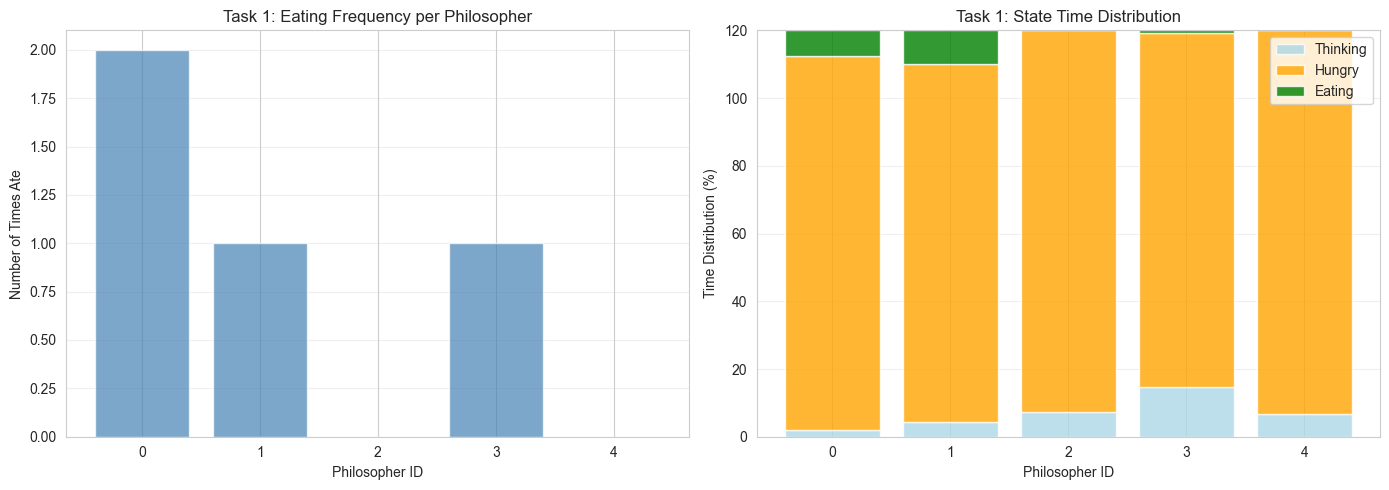

In [7]:
# task 1 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart of eat counts
eat_counts = [p.eat_count for p in sim1.philosophers]
axes[0].bar(range(5), eat_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Philosopher ID')
axes[0].set_ylabel('Number of Times Ate')
axes[0].set_title('Task 1: Eating Frequency per Philosopher')
axes[0].set_xticks(range(5))
axes[0].grid(axis='y', alpha=0.3)

# bar chart of time distribution
thinking_pct = [p.total_thinking_time / 100 * 100 for p in sim1.philosophers]
hungry_pct = [p.total_hungry_time / 100 * 100 for p in sim1.philosophers]
eating_pct = [p.total_eating_time / 100 * 100 for p in sim1.philosophers]

x = np.arange(5)
axes[1].bar(x, thinking_pct, label='Thinking', color='lightblue', alpha=0.8)
axes[1].bar(x, hungry_pct, bottom=thinking_pct, label='Hungry', color='orange', alpha=0.8)
axes[1].bar(x, eating_pct, bottom=np.array(thinking_pct) + np.array(hungry_pct), label='Eating', color='green', alpha=0.8)
axes[1].set_xlabel('Philosopher ID')
axes[1].set_ylabel('Time Distribution (%)')
axes[1].set_title('Task 1: State Time Distribution')
axes[1].set_xticks(range(5))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

The results are very poor but it is expected since on this step we dont have detection and prevention mechanisms yet.

# Task 2: Deadlock Detection

Enable deadlock detection to identify when all philosophers are hungry with one chopstick each.

In [8]:
random.seed(100)
np.random.seed(100)

sim2 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="none",
    halt_on_deadlock=True
)

sim2.run(max_time=120.0)
sim2.print_statistics()

Simulation Statistics (Time: 0 to 19.26)
Strategy: NONE
*** SIMULATION HALTED DUE TO DEADLOCK ***

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            2            9.6             51.1            39.3           
1            1            21.8            26.7            51.5           
2            0            38.2            61.8            0.0            
3            1            76.0            20.3            3.7            
4            0            34.2            65.8            0.0            

Total Eats: 4
Average Eats per Philosopher: 0.80

Deadlocks Detected: 1
Deadlock Times: [19.260710064479532]


In [9]:
mc_detect_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="none", halt_on_deadlock=True),
    runs=100, max_time=120.0, base_seed=1000
)
summarize_detailed(mc_detect_d, "Detection")

=== Detection (Detailed) ===
Runs: 100
Avg total eats: 45.12 ± 9.68
Avg eats/philosopher: 9.02 ± 1.94
Avg min/max eats: 7.01 / 11.16
Avg Gini (fairness): 0.092
Deadlock runs: 11/100
Avg first deadlock time: 71.91
Per-philosopher avg eats: [9.29, 8.82, 9.06, 9.05, 8.9]
Per-philosopher std eats: [2.36, 2.6, 2.56, 2.42, 2.61]
Per-philosopher avg thinking time: [45.6, 44.97, 46.94, 48.18, 47.44]
Per-philosopher avg hungry time:   [40.99, 42.88, 41.08, 40.14, 42.37]
Per-philosopher avg eating time:   [28.11, 26.86, 26.69, 26.39, 24.89]
Per-philosopher std thinking time: [14.07, 13.51, 14.02, 15.14, 14.83]
Per-philosopher std hungry time:   [11.89, 14.25, 12.69, 14.68, 14.34]
Per-philosopher std eating time:   [8.72, 9.23, 10.25, 8.99, 9.25]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



Here is the same basic simulation + deadlock detection, where we can see that deadlock was detected and simulation was stopped at 19.26 mins with 4 total eats.

# Task 3: Deadlock Prevention

Implementation of 2 prevention strategies:
1. **Priority Ordering**: Always pick lower id chopstick first
2. **Timeout Strategy**: Release chopsticks after timeout and retry

In [10]:
def run_compare(name, sim_kwargs, max_time=120.0, seed=123):
    random.seed(seed)
    np.random.seed(seed)
    sim = DiningPhilosophersSimulation(**sim_kwargs)
    sim.run(max_time=max_time)
    print(f'--- {name} ---')
    sim.print_statistics()
    return sim

# Left‑first chopstick approach
lf_random = run_compare(
    'Left‑First / Randomized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=False),
    max_time=120.0, seed=100
)

lf_sync = run_compare(
    'Left‑First / Synchronized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=True, deadlock_prone=True, halt_on_deadlock=True),
    max_time=120.0, seed=100
)

# Lowest‑ID first approach
pr_random = run_compare(
    'Lowest-id First / Randomized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=False),
    max_time=120.0, seed=104
)

pr_sync = run_compare(
    'Lowest-id First / Synchronized Start',
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=True, deadlock_prone=False),
    max_time=120.0, seed=104
)


--- Left‑First / Randomized Start ---
Simulation Statistics (Time: 0 to 120.00)
Strategy: NONE

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            7            27.6            44.8            27.5           
1            10           23.2            47.2            29.6           
2            8            41.3            50.6            8.0            
3            9            44.3            40.1            15.7           
4            6            35.2            48.6            16.2           

Total Eats: 40
Average Eats per Philosopher: 8.00

Deadlocks Detected: 3
Deadlock Times: [19.260710064479532, 19.465207086519026, 19.5135711313228]
--- Left‑First / Synchronized Start ---
Simulation Statistics (Time: 0 to 0.00)
Strategy: NONE
Deadlock-prone timing: tighter think/eat times
Synchronized start: all hungry at t=0
*** SIMULATION HALTED DUE TO DEADLOCK ***

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            0

In [11]:
mc_lf_random = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=False),
    runs=100, max_time=120.0, base_seed=1000
)

mc_lf_sync = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='none', synchronized_start=True, deadlock_prone=True, halt_on_deadlock=True),
    runs=100, max_time=120.0, base_seed=1000
)

mc_pr_random = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=False),
    runs=100, max_time=120.0, base_seed=1000
)

mc_pr_sync = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy='priority', synchronized_start=True, deadlock_prone=False),
    runs=100, max_time=120.0, base_seed=1000
)

summarize_detailed(mc_lf_random, 'Left-First / Randomized (MC)')
summarize_detailed(mc_lf_sync, 'Left-First / Synchronized (MC)')
summarize_detailed(mc_pr_random, 'Lowest-id first / Randomized (MC)')
summarize_detailed(mc_pr_sync, 'Lowest-id first / Synchronized (MC)')

=== Left-First / Randomized (MC) (Detailed) ===
Runs: 100
Avg total eats: 47.35 ± 6.37
Avg eats/philosopher: 9.47 ± 1.27
Avg min/max eats: 7.41 / 11.63
Avg Gini (fairness): 0.087
Deadlock runs: 11/100
Avg first deadlock time: 71.91
Per-philosopher avg eats: [9.7, 9.28, 9.54, 9.46, 9.37]
Per-philosopher std eats: [1.98, 2.1, 2.07, 2.05, 2.09]
Per-philosopher avg thinking time: [47.43, 46.82, 48.99, 49.67, 49.31]
Per-philosopher avg hungry time:   [43.36, 45.12, 43.08, 42.7, 44.68]
Per-philosopher avg eating time:   [29.22, 28.06, 27.93, 27.64, 26.02]
Per-philosopher std thinking time: [12.03, 11.64, 12.23, 13.24, 12.74]
Per-philosopher std hungry time:   [10.77, 13.0, 11.24, 13.8, 13.28]
Per-philosopher std eating time:   [7.92, 8.53, 9.32, 7.88, 8.27]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Left-First / Synchronized (MC) (Detailed) ===
Runs: 100
Avg total eats: 0.00 ± 0.00
Avg eats/philosopher: 0.00 ± 0.00
Avg min/max eats: 0.00 / 0.00
Avg Gini (fairness): 0.000
De

In [12]:
# S2: Timeout Strategy
random.seed(200)
np.random.seed(200)
sim3b = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="timeout",
    timeout_duration=2.0,
    deadlock_prone=False,
    synchronized_start=False
)

sim3b.run(max_time=120.0)
sim3b.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: TIMEOUT
Timeout Duration: 2.0

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            11           52.2            22.2            25.6           
1            11           51.5            19.7            28.8           
2            13           49.0            37.8            13.1           
3            12           52.0            18.6            29.4           
4            7            49.6            29.6            20.8           

Total Eats: 54
Average Eats per Philosopher: 10.80

Deadlocks Detected: 0


In [13]:
mc_timeout_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=False),
    runs=100, max_time=120.0, base_seed=1000
)
summarize_detailed(mc_timeout_d, "Timeout")

=== Timeout (Detailed) ===
Runs: 100
Avg total eats: 53.33 ± 5.70
Avg eats/philosopher: 10.67 ± 1.14
Avg min/max eats: 8.18 / 13.26
Avg Gini (fairness): 0.093
Deadlock runs: 5/100
Avg first deadlock time: 55.98
Avg timeout releases/run: 23.73 ± 6.47
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [10.75, 10.81, 10.7, 10.5, 10.57]
Per-philosopher std eats: [2.14, 2.45, 2.37, 2.16, 2.12]
Per-philosopher avg thinking time: [53.73, 52.74, 52.75, 55.27, 55.09]
Per-philosopher avg hungry time:   [35.98, 35.24, 34.73, 33.67, 32.86]
Per-philosopher avg eating time:   [30.29, 32.02, 32.51, 31.05, 32.04]
Per-philosopher std thinking time: [10.24, 11.72, 12.33, 11.7, 13.5]
Per-philosopher std hungry time:   [11.26, 10.59, 11.47, 10.84, 10.64]
Per-philosopher std eating time:   [9.3, 8.18, 8.86, 8.13, 9.81]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



**Here is 2 cases of Priority Ordering strategy:**
1. Left-first: each philosopher grabs their left chopstick first. \
       This is more symmetric and can look fairer in randomized starts, but it does NOT guarantee deadlock prevention (synchronized start can deadlock). \
2. Lowest-id First: each philosopher grabs the lower-ID chopstick first. \
       This removes circular wait -> deadlock-free by design, but can bias fairness (hotspot around the lowest-ID chopstick).

**Insight from results:**
- Left-first (randomized) looks more balanced here, but it can deadlock under synchronized start.
- Lowest-id prevents deadlock, but can be unfair in eat counts among philosophers.
- Trade-off: fairness vs guaranteed deadlock prevention.

## Comparison of All Strategies

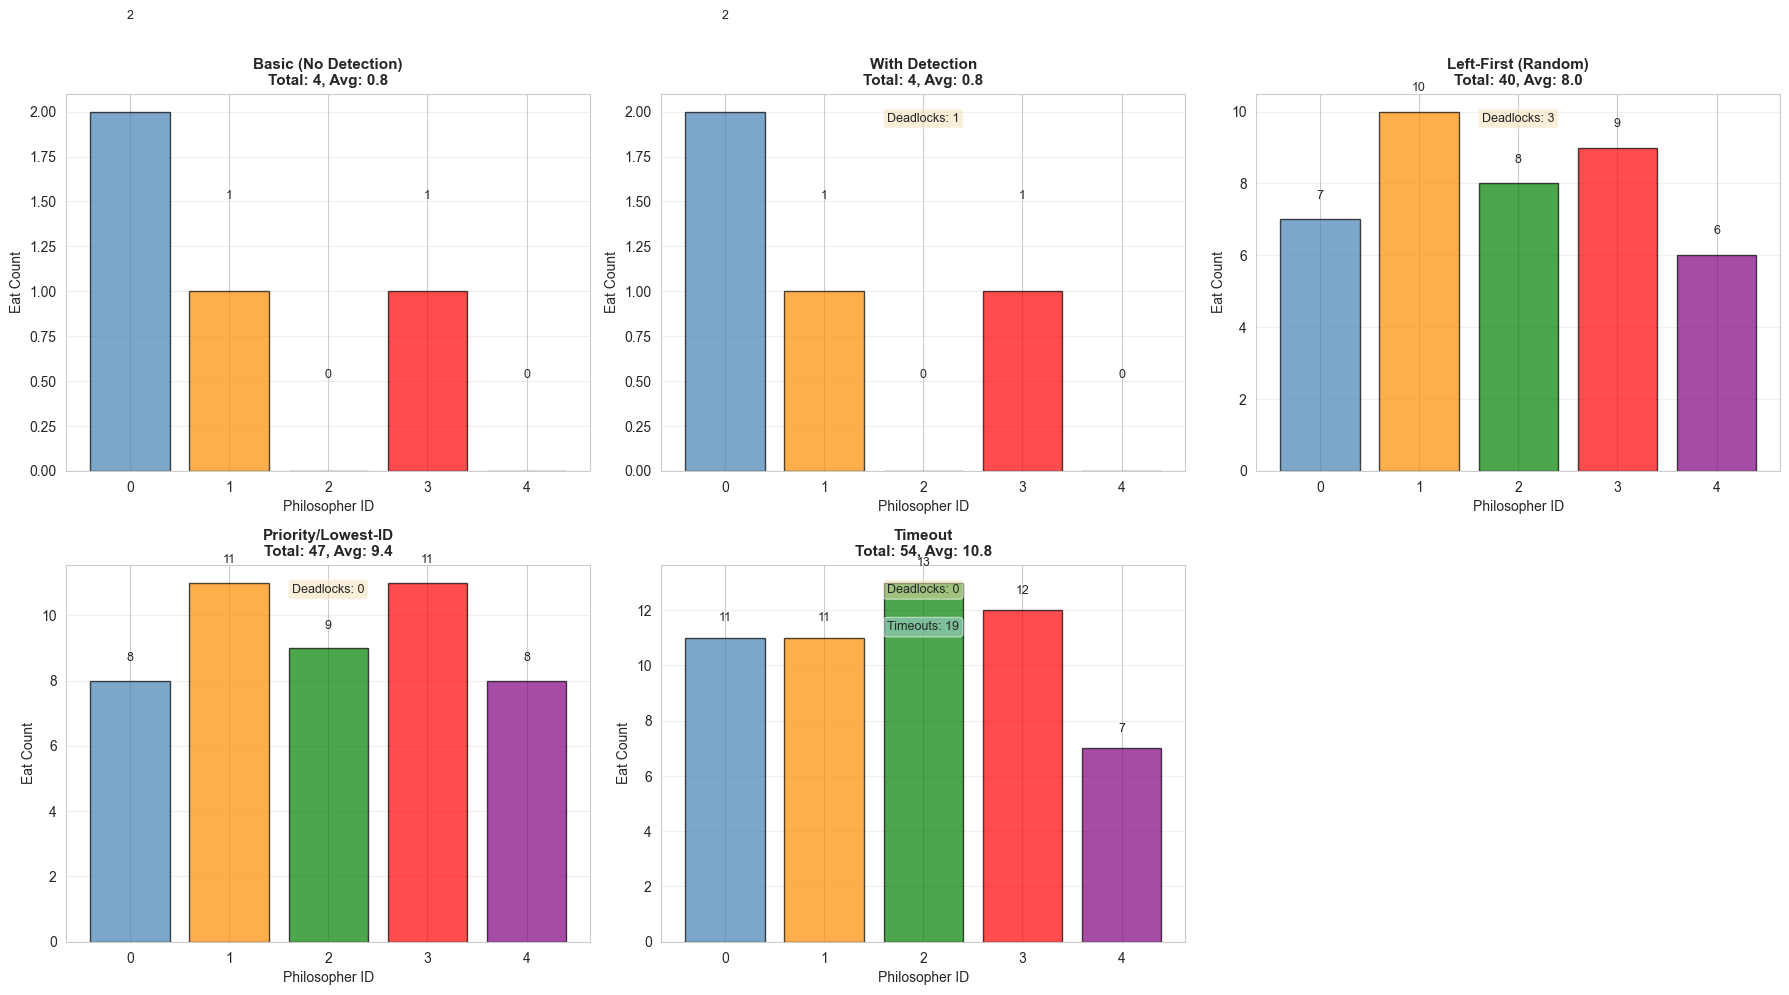


KEY INSIGHTS FROM TASK 3 COMPARISONS:
1. Basic (No Detection): May deadlock, no recovery mechanism
2. With Detection: Detects deadlocks but doesn't prevent them
3. Left-First: Fair distribution, but can deadlock
4. Priority/Lowest-ID: Prevents deadlock BUT creates unfairness (lower IDs eat more)
5. Timeout: Prevents persistent deadlock, maintains fairness


In [14]:
strategies = {
    'Basic (No Detection)': sim1,
    'With Detection': sim2,
    'Left-First (Random)': lf_random,
    'Priority/Lowest-ID': pr_random,
    'Timeout': sim3b
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, sim) in enumerate(strategies.items()):
    eat_counts = [p.eat_count for p in sim.philosophers]

    # Color code by philosopher ID
    colors = ['steelblue', 'darkorange', 'green', 'red', 'purple']

    axes[idx].bar(
        range(5),
        eat_counts,
        color=colors,
        alpha=0.7,
        edgecolor='black'
    )

    axes[idx].set_xlabel('Philosopher ID', fontsize=10)
    axes[idx].set_ylabel('Eat Count', fontsize=10)
    axes[idx].set_title(
        f'{name}\n'
        f'Total: {sum(eat_counts)}, Avg: {sum(eat_counts) / 5:.1f}',
        fontsize=11,
        fontweight='bold'
    )
    axes[idx].set_xticks(range(5))
    axes[idx].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, count in enumerate(eat_counts):
        axes[idx].text(
            i,
            count + 0.5,
            str(count),
            ha='center',
            va='bottom',
            fontsize=9
        )

    # Add deadlock info if applicable
    if hasattr(sim, 'deadlock_count') and sim.deadlock_detection:
        axes[idx].text(
            0.5,
            0.95,
            f'Deadlocks: {sim.deadlock_count}',
            transform=axes[idx].transAxes,
            ha='center',
            va='top',
            bbox=dict(
                boxstyle='round',
                facecolor='wheat',
                alpha=0.5
            ),
            fontsize=9
        )

    # Add timeout releases info if applicable
    if hasattr(sim, 'timeout_release_count') and sim.timeout_release_count > 0:
        axes[idx].text(
            0.5,
            0.85,
            f'Timeouts: {sim.timeout_release_count}',
            transform=axes[idx].transAxes,
            ha='center',
            va='top',
            bbox=dict(
                boxstyle='round',
                facecolor='lightblue',
                alpha=0.5
            ),
            fontsize=9
        )

# Hide the 6th subplot (empty)
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("KEY INSIGHTS FROM TASK 3 COMPARISONS:")
print("=" * 80)
print("1. Basic (No Detection): May deadlock, no recovery mechanism")
print("2. With Detection: Detects deadlocks but doesn't prevent them")
print("3. Left-First: Fair distribution, but can deadlock")
print("4. Priority/Lowest-ID: Prevents deadlock BUT creates unfairness (lower IDs eat more)")
print("5. Timeout: Prevents persistent deadlock, maintains fairness")


MACRO: Strategy Comparison Across 100 MC Runs


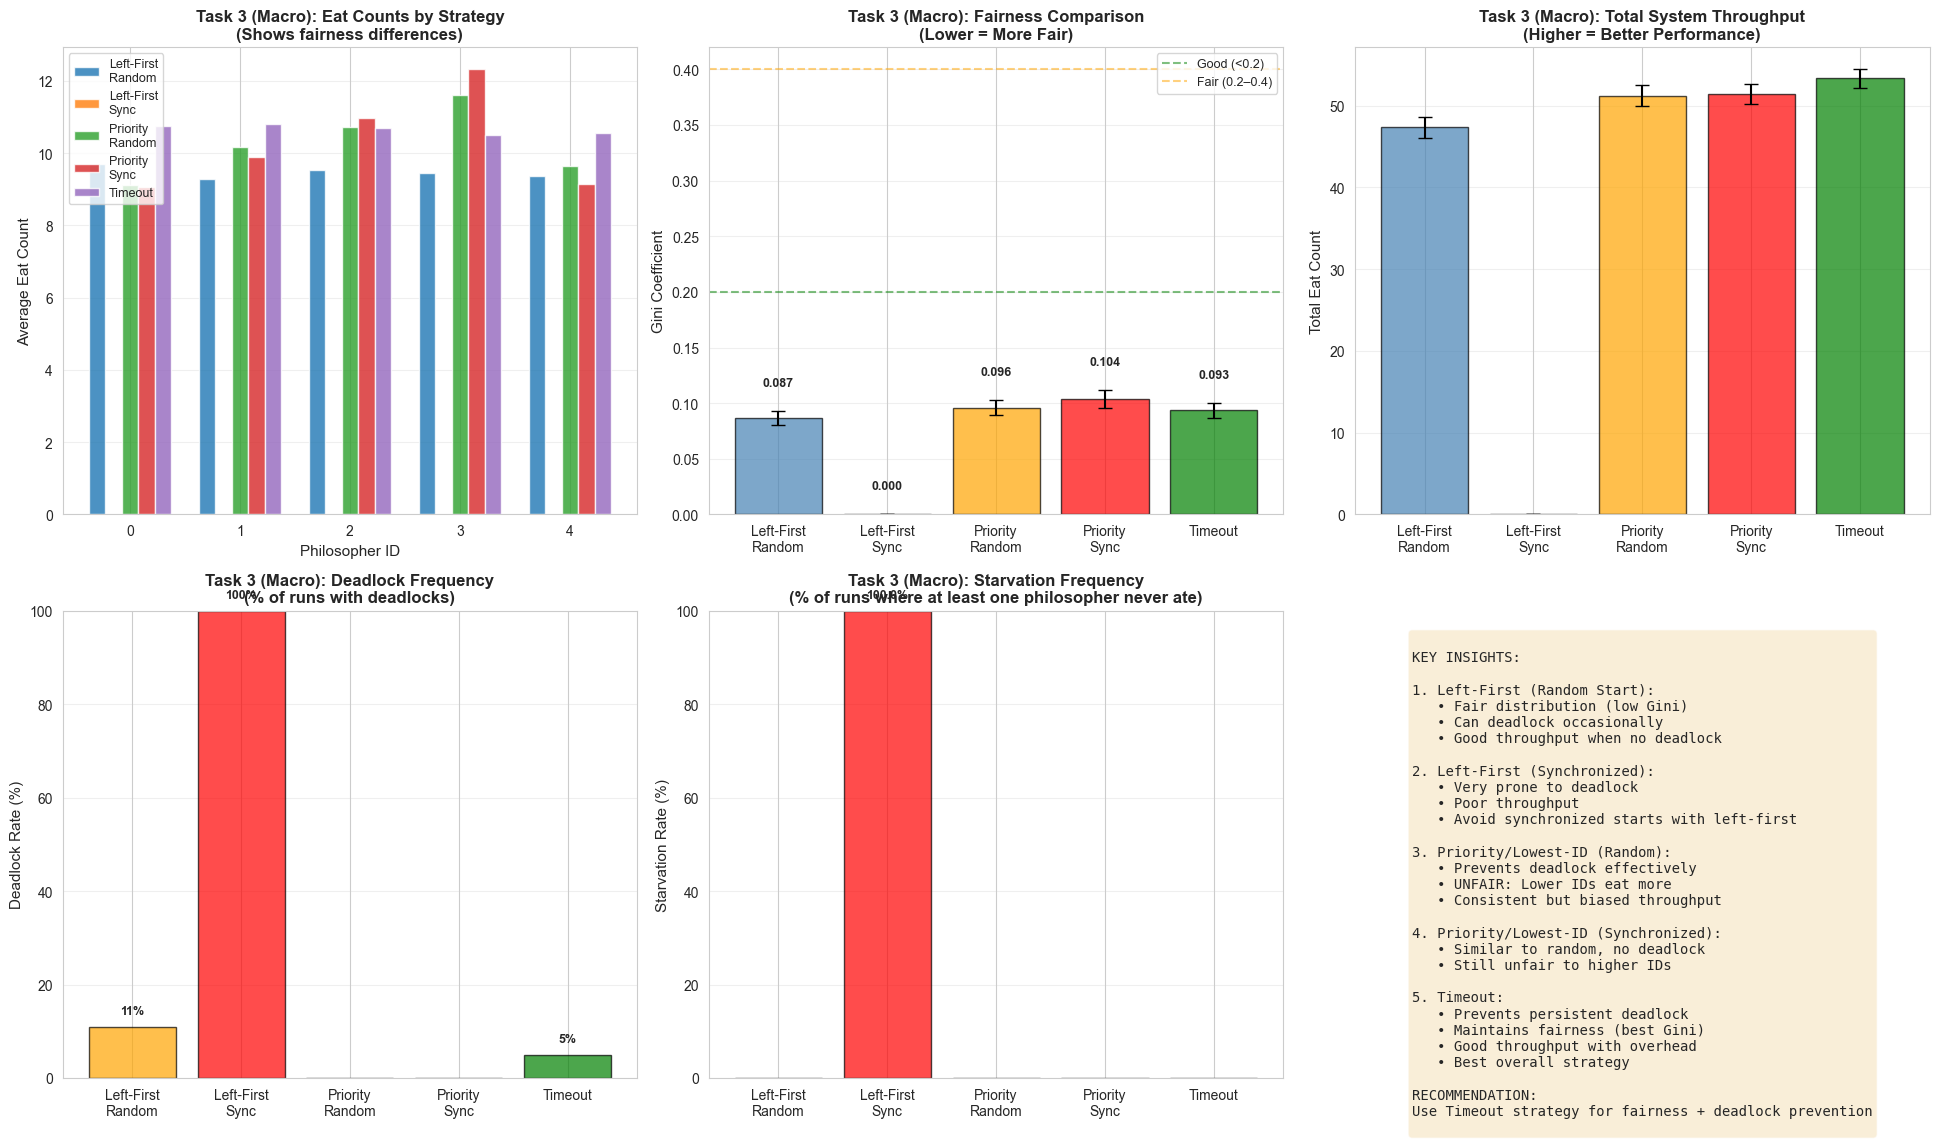


 STRATEGY COMPARISON SUMMARY (100 MC runs)
Strategy                 Gini  TotalEats  Deadlock%  Starvation%
--------------------------------------------------------------------------------
Left-First Random       0.087       47.4       11.0          0.0
Left-First Sync         0.000        0.0      100.0        100.0
Priority Random         0.096       51.2        0.0          0.0
Priority Sync           0.104       51.4        0.0          0.0
Timeout                 0.093       53.3        5.0          0.0


In [15]:
# --- MACRO INVESTIGATION: Strategy Comparison (MC Analysis) ---

print("\n" + "=" * 80)
print("MACRO: Strategy Comparison Across 100 MC Runs")
print("=" * 80)

mc_strategies = {
    'Left-First\nRandom': mc_lf_random,
    'Left-First\nSync': mc_lf_sync,
    'Priority\nRandom': mc_pr_random,
    'Priority\nSync': mc_pr_sync,
    'Timeout': mc_timeout_d
}

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# ------------------------------------------------------------------
# Plot 1: Average eat counts comparison
# ------------------------------------------------------------------
idx = 0
width = 0.15
x = np.arange(5)

for i, (name, df) in enumerate(mc_strategies.items()):
    eat_counts_runs = np.array([row for row in df['eat_counts']])
    mean_eats = eat_counts_runs.mean(axis=0)

    axes[idx].bar(
        x + i * width,
        mean_eats,
        width,
        label=name,
        alpha=0.8
    )

axes[idx].set_xlabel('Philosopher ID', fontsize=11)
axes[idx].set_ylabel('Average Eat Count', fontsize=11)
axes[idx].set_title(
    'Task 3 (Macro): Eat Counts by Strategy\n'
    '(Shows fairness differences)',
    fontsize=12,
    fontweight='bold'
)
axes[idx].set_xticks(x + width * 2)
axes[idx].set_xticklabels(range(5))
axes[idx].legend(fontsize=9, loc='upper left')
axes[idx].grid(axis='y', alpha=0.3)

# ------------------------------------------------------------------
# Plot 2: Gini coefficient comparison (fairness)
# ------------------------------------------------------------------
idx = 1

gini_means = [df['gini_eats'].mean() for df in mc_strategies.values()]
gini_stds = [df['gini_eats'].std() for df in mc_strategies.values()]
gini_ci = [1.96 * s / np.sqrt(100) for s in gini_stds]

axes[idx].bar(
    range(len(mc_strategies)),
    gini_means,
    yerr=gini_ci,
    capsize=5,
    color=['steelblue', 'navy', 'orange', 'red', 'green'],
    alpha=0.7,
    edgecolor='black'
)

axes[idx].set_xticks(range(len(mc_strategies)))
axes[idx].set_xticklabels(mc_strategies.keys(), fontsize=10)
axes[idx].set_ylabel('Gini Coefficient', fontsize=11)
axes[idx].set_title(
    'Task 3 (Macro): Fairness Comparison\n'
    '(Lower = More Fair)',
    fontsize=12,
    fontweight='bold'
)
axes[idx].axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Good (<0.2)')
axes[idx].axhline(y=0.4, color='orange', linestyle='--', alpha=0.5, label='Fair (0.2–0.4)')
axes[idx].legend(fontsize=9)
axes[idx].grid(axis='y', alpha=0.3)

for i, (m, ci) in enumerate(zip(gini_means, gini_ci)):
    axes[idx].text(
        i,
        m + ci + 0.02,
        f'{m:.3f}',
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

# ------------------------------------------------------------------
# Plot 3: Total eats comparison (throughput)
# ------------------------------------------------------------------
idx = 2

total_means = [df['total_eats'].mean() for df in mc_strategies.values()]
total_stds = [df['total_eats'].std() for df in mc_strategies.values()]
total_ci = [1.96 * s / np.sqrt(100) for s in total_stds]

axes[idx].bar(
    range(len(mc_strategies)),
    total_means,
    yerr=total_ci,
    capsize=5,
    color=['steelblue', 'navy', 'orange', 'red', 'green'],
    alpha=0.7,
    edgecolor='black'
)

axes[idx].set_xticks(range(len(mc_strategies)))
axes[idx].set_xticklabels(mc_strategies.keys(), fontsize=10)
axes[idx].set_ylabel('Total Eat Count', fontsize=11)
axes[idx].set_title(
    'Task 3 (Macro): Total System Throughput\n'
    '(Higher = Better Performance)',
    fontsize=12,
    fontweight='bold'
)
axes[idx].grid(axis='y', alpha=0.3)

# ------------------------------------------------------------------
# Plot 4: Deadlock rate
# ------------------------------------------------------------------
idx = 3

deadlock_counts = [
    len([1 for d in df['deadlocks'] if d > 0])
    for df in mc_strategies.values()
]
deadlock_rates = [c / 100 * 100 for c in deadlock_counts]

axes[idx].bar(
    range(len(mc_strategies)),
    deadlock_rates,
    color=[
        'red' if r > 50 else 'orange' if r > 10 else 'green'
        for r in deadlock_rates
    ],
    alpha=0.7,
    edgecolor='black'
)

axes[idx].set_xticks(range(len(mc_strategies)))
axes[idx].set_xticklabels(mc_strategies.keys(), fontsize=10)
axes[idx].set_ylabel('Deadlock Rate (%)', fontsize=11)
axes[idx].set_title(
    'Task 3 (Macro): Deadlock Frequency\n'
    '(% of runs with deadlocks)',
    fontsize=12,
    fontweight='bold'
)
axes[idx].set_ylim([0, 100])
axes[idx].grid(axis='y', alpha=0.3)

for i, rate in enumerate(deadlock_rates):
    if rate > 1:
        axes[idx].text(
            i,
            rate + 2,
            f'{rate:.0f}%',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

# ------------------------------------------------------------------
# Plot 5: Starvation rate (zero-eat rate)
# ------------------------------------------------------------------
idx = 4
starvation_rates = []

for df in mc_strategies.values():
    eat_counts_runs = np.array([row for row in df['eat_counts']])
    zero_rate = (eat_counts_runs.min(axis=1) == 0).mean() * 100
    starvation_rates.append(zero_rate)

axes[idx].bar(
    range(len(mc_strategies)),
    starvation_rates,
    color=[
        'red' if r > 20 else 'orange' if r > 5 else 'green'
        for r in starvation_rates
    ],
    alpha=0.7,
    edgecolor='black'
)

axes[idx].set_xticks(range(len(mc_strategies)))
axes[idx].set_xticklabels(mc_strategies.keys(), fontsize=10)
axes[idx].set_ylabel('Starvation Rate (%)', fontsize=11)
axes[idx].set_title(
    'Task 3 (Macro): Starvation Frequency\n'
    '(% of runs where at least one philosopher never ate)',
    fontsize=12,
    fontweight='bold'
)
axes[idx].set_ylim([0, 100])
axes[idx].grid(axis='y', alpha=0.3)

for i, rate in enumerate(starvation_rates):
    if rate > 1:
        axes[idx].text(
            i,
            rate + 2,
            f'{rate:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

# ------------------------------------------------------------------
# Plot 6: Summary text
# ------------------------------------------------------------------
idx = 5
axes[idx].axis('off')

summary_text = """
KEY INSIGHTS:

1. Left-First (Random Start):
   • Fair distribution (low Gini)
   • Can deadlock occasionally
   • Good throughput when no deadlock

2. Left-First (Synchronized):
   • Very prone to deadlock
   • Poor throughput
   • Avoid synchronized starts with left-first

3. Priority/Lowest-ID (Random):
   • Prevents deadlock effectively
   • UNFAIR: Lower IDs eat more
   • Consistent but biased throughput

4. Priority/Lowest-ID (Synchronized):
   • Similar to random, no deadlock
   • Still unfair to higher IDs

5. Timeout:
   • Prevents persistent deadlock
   • Maintains fairness (best Gini)
   • Good throughput with overhead
   • Best overall strategy

RECOMMENDATION:
Use Timeout strategy for fairness + deadlock prevention
"""

axes[idx].text(
    0.1,
    0.95,
    summary_text,
    transform=axes[idx].transAxes,
    fontsize=10,
    verticalalignment='top',
    family='monospace',
    bbox=dict(
        boxstyle='round',
        facecolor='wheat',
        alpha=0.5
    )
)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Print summary table
# ------------------------------------------------------------------
print("\n" + "=" * 80)
print(" STRATEGY COMPARISON SUMMARY (100 MC runs)")
print("=" * 80)
print(f"{'Strategy':<20} {'Gini':>8} {'TotalEats':>10} {'Deadlock%':>10} {'Starvation%':>12}")
print("-" * 80)

for i, (name, df) in enumerate(mc_strategies.items()):
    name_clean = name.replace('\n', ' ')
    gini_m = gini_means[i]
    total_m = total_means[i]
    deadlock_pct = deadlock_rates[i]
    starve_pct = starvation_rates[i]

    print(
        f"{name_clean:<20} "
        f"{gini_m:>8.3f} "
        f"{total_m:>10.1f} "
        f"{deadlock_pct:>10.1f} "
        f"{starve_pct:>12.1f}"
    )

print("=" * 80)

In [16]:
summary_data = []
for name, sim in strategies.items():
    total_eats = sum(p.eat_count for p in sim.philosophers)
    avg_eats = total_eats / 5
    std_eats = np.std([p.eat_count for p in sim.philosophers])
    deadlocks = sim.deadlock_count if hasattr(sim, 'deadlock_count') else 'N/A'
    
    summary_data.append({
        'Strategy': name,
        'Total Eats': total_eats,
        'Avg Eats': f"{avg_eats:.2f}",
        'Std Dev': f"{std_eats:.2f}",
        'Deadlocks': deadlocks
    })

df_summary = pd.DataFrame(summary_data)
print("STRATEGY COMPARISON SUMMARY")
print(df_summary.to_string(index=False))

STRATEGY COMPARISON SUMMARY
            Strategy  Total Eats Avg Eats Std Dev  Deadlocks
Basic (No Detection)           4     0.80    0.75          0
      With Detection           4     0.80    0.75          1
 Left-First (Random)          40     8.00    1.41          3
  Priority/Lowest-ID          47     9.40    1.36          0
             Timeout          54    10.80    2.04          0


# Task 4: Starvation Avoidance

Implementing a fairness mechanism so that all philosophers have a chance to eat.

To prevent starvation, the model implements a priority-based scheduling mechanism based on each philosopher’s waiting time. Whenever a philosopher is about to picked for acquiring chopsticks for eating the largest elapsed time (current_time - last_ate_time) is tracked and the philospher with the highest value is chosen. Only this philosopher is permitted to attempt to acquire chopsticks at that moment.

Simulation run with starvation avoidance on:

In [17]:
# S4: Starvation Avoidance
random.seed(100)
np.random.seed(100)
sim4 = DiningPhilosophersSimulation(
    num_philosophers=5,
    deadlock_detection=True,
    prevention_strategy="priority",
    starvation_prevention=True,
    deadlock_prone=False,    
    synchronized_start=False, 
)

sim4.run(max_time=120.0)
sim4.print_statistics()

Simulation Statistics (Time: 0 to 120.00)
Strategy: PRIORITY

Philosopher  Eat Count    Thinking %      Hungry %        Eating %       
0            8            30.6            37.8            31.6           
1            9            34.2            46.9            18.9           
2            9            36.8            40.5            22.7           
3            8            29.1            45.8            25.1           
4            7            42.2            36.5            21.3           

Total Eats: 41
Average Eats per Philosopher: 8.20

Deadlocks Detected: 0


Now the distribution of the eating events for all philosophers should be more balanced then before when including starvation avoidance.

Plotting the number of eating times for the previous simulation run as well as the relative time of the different states for each philosopher should give an idea on how fair the model is now in terms of eating order

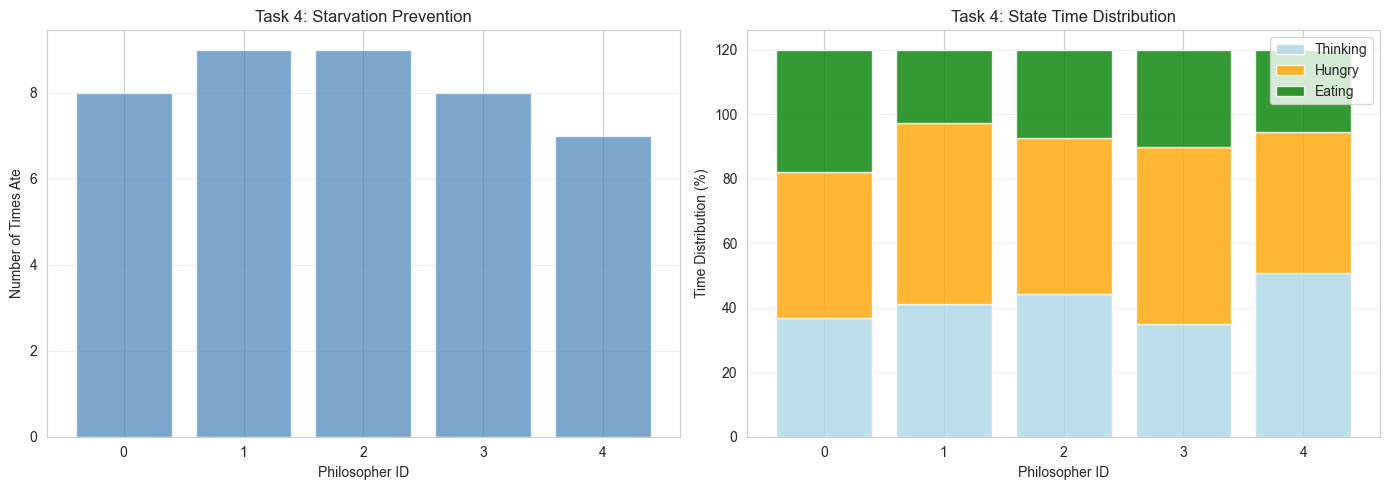

In [18]:
# task 4 results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart of eat counts
eat_counts = [p.eat_count for p in sim4.philosophers]
axes[0].bar(range(5), eat_counts, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Philosopher ID')
axes[0].set_ylabel('Number of Times Ate')
axes[0].set_title('Task 4: Starvation Prevention')
axes[0].set_xticks(range(5))
axes[0].grid(axis='y', alpha=0.3)

# bar chart of time distribution
thinking_pct = [p.total_thinking_time / 100 * 100 for p in sim4.philosophers]
hungry_pct = [p.total_hungry_time / 100 * 100 for p in sim4.philosophers]
eating_pct = [p.total_eating_time / 100 * 100 for p in sim4.philosophers]

x = np.arange(5)
axes[1].bar(x, thinking_pct, label='Thinking', color='lightblue', alpha=0.8)
axes[1].bar(x, hungry_pct, bottom=thinking_pct, label='Hungry', color='orange', alpha=0.8)
axes[1].bar(x, eating_pct, bottom=np.array(thinking_pct) + np.array(hungry_pct), label='Eating', color='green', alpha=0.8)
axes[1].set_xlabel('Philosopher ID')
axes[1].set_ylabel('Time Distribution (%)')
axes[1].set_title('Task 4: State Time Distribution')
axes[1].set_xticks(range(5))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

With the strict eating rule of the starvation avoidance, the eating counts seem to vary less among the philosophers.
The duration of the hungry state also seems to be evenly disributed, indicating fairness.

In [19]:
def compute_statistics(sim):
    eat_counts = np.array([p.eat_count for p in sim.philosophers])
    hungry_times = np.array([p.total_hungry_time for p in sim.philosophers])
    eating_times = np.array([p.total_eating_time for p in sim.philosophers])

    stats = {
        "total_time": sim.current_time,
        "total_eats": eat_counts.sum(),
        "avg_eats": eat_counts.mean(),
        "eat_std": eat_counts.std(),
        "min_eats": eat_counts.min(),
        "max_eats": eat_counts.max(),

        "avg_hungry_time": hungry_times.mean(),
        "max_hungry_time": hungry_times.max(),

        "avg_eating_time": eating_times.mean(),

        "throughput": eat_counts.sum() / sim.current_time if sim.current_time > 0 else 0
    }

    return stats


def print_statistics(stats, title="Simulation Statistics"):
    print(f"\n{title}")
    print("-" * len(title))

    print(f"Total simulation time      : {stats['total_time']:.2f}")
    print(f"Total eats                 : {stats['total_eats']}")
    print(f"Average eats               : {stats['avg_eats']:.2f}")
    print(f"Eat count std deviation    : {stats['eat_std']:.2f}")
    print(f"Min / Max eats             : {stats['min_eats']} / {stats['max_eats']}")
    print()
    print(f"Average hungry time        : {stats['avg_hungry_time']:.2f}")
    print(f"Maximum hungry time        : {stats['max_hungry_time']:.2f}")
    print(f"Average eating time        : {stats['avg_eating_time']:.2f}")
    print()
    print(f"Throughput (eats / time)   : {stats['throughput']:.3f}")

stats_no_prevention = compute_statistics(pr_random)
stats_with_prevention = compute_statistics(sim4)

print_statistics(stats_no_prevention, "Without Starvation Prevention")
print_statistics(stats_with_prevention, "With Starvation Prevention")



Without Starvation Prevention
-----------------------------
Total simulation time      : 120.00
Total eats                 : 47
Average eats               : 9.40
Eat count std deviation    : 1.36
Min / Max eats             : 8 / 11

Average hungry time        : 37.82
Maximum hungry time        : 61.82
Average eating time        : 29.70

Throughput (eats / time)   : 0.392

With Starvation Prevention
--------------------------
Total simulation time      : 120.00
Total eats                 : 41
Average eats               : 8.20
Eat count std deviation    : 0.75
Min / Max eats             : 7 / 9

Average hungry time        : 49.82
Maximum hungry time        : 56.33
Average eating time        : 28.68

Throughput (eats / time)   : 0.342


As a baseline for comparison, we use the simulation run with priority ordering and compare it against a simulation using the same settings with starvation avoidance enabled.

Its clear that starvation avoidance introduces fairness into our model (lower std of eating counts and smaller min max eats intervals) with the cost of higher hungry state times and therefore lower average and maximum eating count times.

In [20]:
mc_basic_starv_avoid_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=False, prevention_strategy="none", starvation_prevention=True),
    runs=100, max_time=120.0, base_seed=7000
)

mc_priority_starv_avoid_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="priority", starvation_prevention=True),
    runs=100, max_time=120.0, base_seed=7000
)

mc_timeout_starv_avoid_d = run_monte_carlo_detailed(
    dict(num_philosophers=5, deadlock_detection=True, prevention_strategy="timeout",
         timeout_duration=2.0, starvation_prevention=True),
    runs=100, max_time=120.0, base_seed=7000
)

summarize_detailed(mc_basic_starv_avoid_d, "Basic + Starvation Prevention")
summarize_detailed(mc_priority_starv_avoid_d, "Priority + Starvation Prevention")
summarize_detailed(mc_timeout_starv_avoid_d, "Timeout + Starvation Prevention")

=== Basic + Starvation Prevention (Detailed) ===
Runs: 100
Avg total eats: 23.63 ± 17.20
Avg eats/philosopher: 4.73 ± 3.44
Avg min/max eats: 3.74 / 5.88
Avg Gini (fairness): 0.183
Deadlock runs: 0/100
Per-philosopher avg eats: [4.76, 4.97, 4.81, 4.6, 4.49]
Per-philosopher std eats: [3.45, 3.71, 3.61, 3.51, 3.44]
Per-philosopher avg thinking time: [29.02, 26.3, 26.55, 27.7, 28.56]
Per-philosopher avg hungry time:   [76.23, 79.13, 79.22, 77.83, 76.98]
Per-philosopher avg eating time:   [14.75, 14.57, 14.23, 14.46, 14.46]
Per-philosopher std thinking time: [18.25, 17.71, 18.56, 18.42, 18.01]
Per-philosopher std hungry time:   [27.83, 27.09, 28.19, 27.92, 28.35]
Per-philosopher std eating time:   [11.93, 12.05, 11.89, 12.86, 12.61]
Zero-eat rate by philosopher: [0.13, 0.15, 0.17, 0.18, 0.2]

=== Priority + Starvation Prevention (Detailed) ===
Runs: 100
Avg total eats: 24.43 ± 18.20
Avg eats/philosopher: 4.89 ± 3.64
Avg min/max eats: 3.89 / 5.95
Avg Gini (fairness): 0.187
Deadlock runs: 0/1

## Comparing the basline 

The following boxplots summarize the resulting distributions of four key metrics, namely
eating frequency, total hungry time, maximum hungry time per run, and fairness measured as
the standard deviation of eating counts.

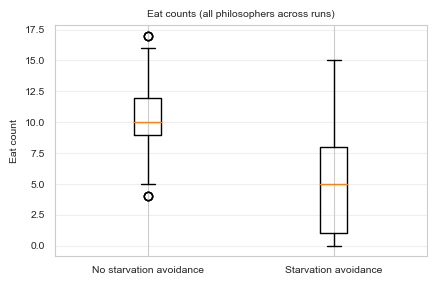

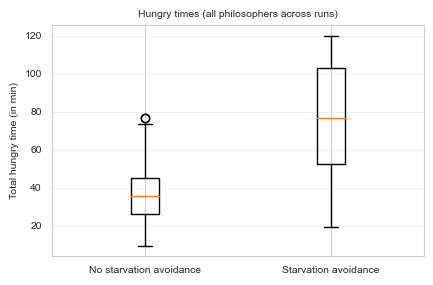

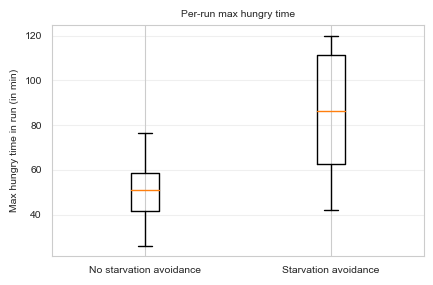

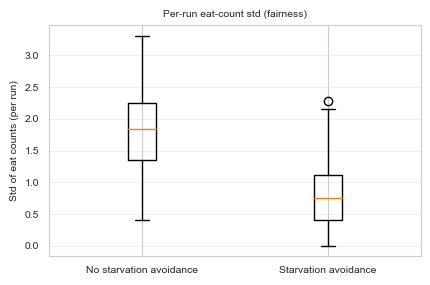

In [21]:

def _flatten_listcol(df, col):
    """Flatten a column that stores lists (one list per run) into 1D array."""
    return np.array([v for row in df[col].dropna().to_list() for v in row], dtype=float)

def _per_run_stat(df, col, stat):
    """Compute per-run summary stat over list-valued column."""
    out = []
    for row in df[col].to_list():
        x = np.array(row, dtype=float)
        if stat == "mean":
            out.append(float(np.mean(x)))
        elif stat == "max":
            out.append(float(np.max(x)))
        elif stat == "min":
            out.append(float(np.min(x)))
        elif stat == "std":
            out.append(float(np.std(x)))
        else:
            raise ValueError("stat must be one of: mean, max, min, std")
    return np.array(out, dtype=float)

def boxplot_compare(a, b, title, ylabel,
                    labels=("No starvation avoidance", "Starvation avoidance")):
    
    plt.figure(figsize=(4.8, 3))
    plt.rcParams.update({
    "font.size": 7.5,
    "axes.labelsize": 7.5,
    "axes.titlesize": 7.5, 
    })

    plt.boxplot([a, b], labels=list(labels), showfliers=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()

def _displayStarvationAvoidanceComparison(mc_no_starv, mc_starv):
    # 1) Eat counts distribution (all philosophers, all runs)
    eats_no  = _flatten_listcol(mc_no_starv, "eat_counts")
    eats_yes = _flatten_listcol(mc_starv, "eat_counts")
    boxplot_compare(eats_no, eats_yes, "Eat counts (all philosophers across runs)", "Eat count")

    # 2) Hungry times distribution (all philosophers, all runs)
    hungry_no  = _flatten_listcol(mc_no_starv, "hungry_times")
    hungry_yes = _flatten_listcol(mc_starv, "hungry_times")
    boxplot_compare(hungry_no, hungry_yes, "Hungry times (all philosophers across runs)", "Total hungry time (in min)")

    # 3) Per-run maximum hungry time (strong “starvation risk” signal)
    max_hungry_no  = _per_run_stat(mc_no_starv, "hungry_times", "max")
    max_hungry_yes = _per_run_stat(mc_starv, "hungry_times", "max")
    boxplot_compare(max_hungry_no, max_hungry_yes, "Per-run max hungry time", "Max hungry time in run (in min)")

    # 4) Fairness: per-run std of eats (lower = more even)
    std_eats_no  = mc_no_starv["std_eats"].astype(float).to_numpy()
    std_eats_yes = mc_starv["std_eats"].astype(float).to_numpy()
    boxplot_compare(std_eats_no, std_eats_yes, "Per-run eat-count std (fairness)", "Std of eat counts (per run)")

_displayStarvationAvoidanceComparison(mc_pr_random,mc_priority_starv_avoid_d)


# Task 5

General settings:

- 100 MC Runs

- simulation will be run for 800 time units (= mins), since we will vary the thinking / eating times + increase number of philosophers

- this task will be based on the simulation engine including the deadlock prevention rules (= solution to task 3)

## Helper Functions for multiple runs

In [22]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 10
SEED = 9000
TIMEOUT_DURATION = 2

# ---- 2) Helper: merge dicts (later dicts override earlier ones) ----
def merge_cfg(*parts):
    cfg = {}
    for p in parts:
        cfg.update(p)
    return cfg

# ---- 3) Helper: auto label from cfg ----
def cfg_label(cfg, title_prefix=""):
    # strategy
    s = cfg.get("prevention_strategy", "none")
    if s == "none":
        strat = "Left-First"
    elif s == "priority":
        strat = "Priority"
    elif s == "timeout":
        strat = f"Timeout(t={cfg.get('timeout_duration', '?')})"
    else:
        strat = s

    # thinking
    if cfg.get("unif_thinking_time", False):
        think = f"Think U({cfg.get('think_unif_low')},{cfg.get('think_unif_high')})"
    else:
        think = "Think Exp(mean=5)"  # your default

    # eating
    if cfg.get("gauss_eating_time", False):
        eat = f"Eat N({cfg.get('eat_mean')},{cfg.get('eat_sigma')}) truncated[{cfg.get('eat_gauss_low')},{cfg.get('eat_gauss_high')}]"
    else:
        eat = "Eat Exp(mean=3)"  # your default

    prefix = (title_prefix + " - ") if title_prefix else ""
    return f"{prefix}{strat} - {think} - {eat}"

# ---- 4) One runner for MC + summary ----
def run_and_summarize(cfg, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix=""):
    df = run_monte_carlo_detailed(cfg, runs=runs, max_time=max_time, base_seed=base_seed)
    summarize_detailed(df, cfg_label(cfg, title_prefix=title_prefix))
    return df

## Inreasing number of philosophers and chopsticks

In [23]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 10
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
)

STRATEGY = {
    "left_first": dict(prevention_strategy="none"),
    "priority": dict(prevention_strategy="priority"),
    "timeout": dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION),
}

In [24]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 10
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
    halt_on_deadlock=True
)

# Left-first
mc_lf_random_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none")),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Priority
mc_pr_random_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority")),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Timeout
mc_timeout_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)


=== Randomized (MC) - Left-First - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 538.74 ± 149.69
Avg eats/philosopher: 53.87 ± 14.97
Avg min/max eats: 47.27 / 61.02
Avg Gini (fairness): 0.050
Deadlock runs: 16/100
Avg first deadlock time: 373.87
Per-philosopher avg eats: [54.17, 54.03, 53.06, 54.12, 54.43, 53.63, 54.25, 53.38, 53.74, 53.93]
Per-philosopher std eats: [15.55, 15.36, 15.19, 15.54, 15.78, 15.64, 15.59, 15.28, 15.49, 15.64]
Per-philosopher avg thinking time: [273.55, 275.87, 276.28, 273.5, 272.58, 274.37, 273.54, 273.59, 273.6, 269.9]
Per-philosopher avg hungry time:   [297.92, 295.32, 295.37, 299.7, 293.01, 300.57, 295.9, 300.67, 298.28, 298.29]
Per-philosopher avg eating time:   [160.35, 160.64, 160.17, 158.62, 166.23, 156.88, 162.38, 157.55, 159.93, 163.63]
Per-philosopher std thinking time: [79.88, 82.05, 79.61, 80.11, 79.42, 79.07, 79.79, 80.75, 81.45, 80.12]
Per-philosopher std hungry time:   [83.2, 84.36, 81.33, 84.3, 79.9, 82.58, 80.16

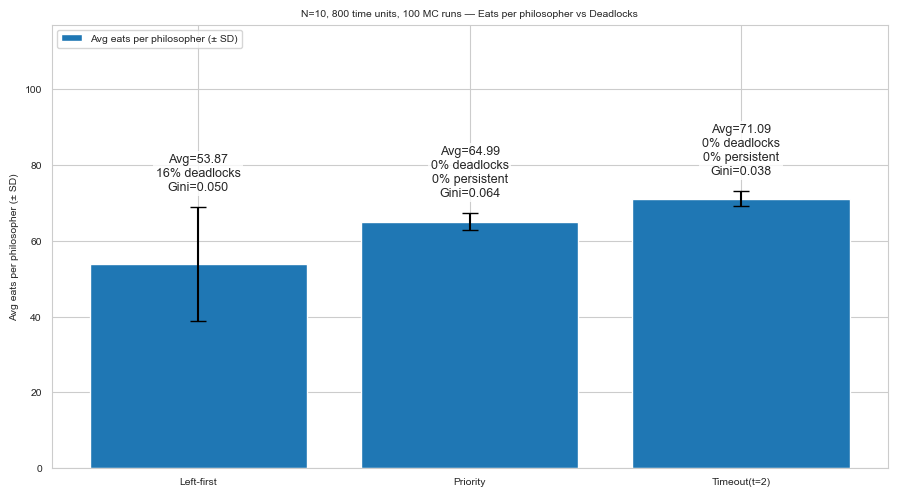

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_strategy_avg_eats_with_deadlock_text(
    dfs,
    labels,
    title=None,
    annotate_gini=True,
    avg_fmt="{:.2f}",
):
    """
    Single-axis bar plot.
    - Bars: mean(avg_eats) with error bars (± SD across Monte Carlo runs)
    - Single annotation block above each bar (top-down):
        1) Avg eats per philosopher
        2) Deadlock rate (% runs with deadlocks > 0)
        3) Persistent-deadlock rate (% runs with persistent_deadlocks > 0), if available
        4) Mean Gini, optional
    """
    if len(dfs) != len(labels):
        raise ValueError("dfs and labels must have the same length")

    mean_avg_eats = []
    std_avg_eats = []
    deadlock_rate_pct = []
    persistent_deadlock_rate_pct = []
    mean_gini = []

    for df in dfs:
        mean_avg_eats.append(df["avg_eats"].mean())
        std_avg_eats.append(df["avg_eats"].std(ddof=1))
        deadlock_rate_pct.append(100.0 * (df["deadlocks"] > 0).mean())
        mean_gini.append(df["gini_eats"].mean())

        if "persistent_deadlocks" in df.columns:
            persistent_deadlock_rate_pct.append(
                100.0 * (df["persistent_deadlocks"] > 0).mean()
            )
        else:
            persistent_deadlock_rate_pct.append(None)

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(9, 5))

    bars = ax.bar(x, mean_avg_eats, yerr=std_avg_eats, capsize=6)

    ax.set_ylabel("Avg eats per philosopher (± SD)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    if title:
        ax.set_title(title)

    y_max = max(m + s for m, s in zip(mean_avg_eats, std_avg_eats))
    ax.set_ylim(0, y_max * 1.60)

    ax.legend([bars], ["Avg eats per philosopher (± SD)"], loc="upper left")

    for i in range(len(labels)):
        parts = [
            f"Avg={avg_fmt.format(mean_avg_eats[i])}",
            f"{deadlock_rate_pct[i]:.0f}% deadlocks",
        ]

        if persistent_deadlock_rate_pct[i] is not None:
            parts.append(f"{persistent_deadlock_rate_pct[i]:.0f}% persistent")

        if annotate_gini:
            parts.append(f"Gini={mean_gini[i]:.3f}")

        ax.text(
            x[i],
            mean_avg_eats[i] + std_avg_eats[i] + y_max * 0.05,
            "\n".join(parts),
            ha="center",
            va="bottom",
            fontsize=9,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.80, pad=2.0),
        )

    fig.tight_layout()
    return fig, ax
dfs = [mc_lf_random_5, mc_pr_random_5, mc_timeout_5]
labels = ["Left-first", "Priority", "Timeout(t=2)"]
title = "N=10, 800 time units, 100 MC runs — Eats per philosopher vs Deadlocks"

plot_strategy_avg_eats_with_deadlock_text(
    dfs=dfs,
    labels=labels,
    title=title,
    annotate_gini=True,
)

plt.show()


# dfs = [mc_lf_random_5, mc_pr_random_5, mc_timeout_5]
# labels = ["Left-first", "Priority", "Timeout(t=2)"]
# title = "N=10, 800 time units, 100 MC runs — Eats per philosopher vs Deadlocks"

# plot_strategy_eats_with_deadlock_text(
#     dfs,
#     labels,
#     title=title,
#     annotate_gini=True,
#     annotate_timeout_releases=False,
# )

# plt.show()


I just see 0 deadlocks in the timeout case. i want to look at that in more detail:

In [26]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(num_philosophers=NUM_PHILS, deadlock_detection=True, halt_on_deadlock= True)

mc_timeout_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)



=== Randomized (MC) - Timeout(t=2) - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 355.02 ± 14.78
Avg eats/philosopher: 71.00 ± 2.96
Avg min/max eats: 64.98 / 77.34
Avg Gini (fairness): 0.034
Deadlock runs: 12/100
Avg first deadlock time: 394.74
Avg timeout releases/run: 159.60 ± 17.77
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [70.93, 71.11, 71.2, 71.06, 70.72]
Per-philosopher std eats: [5.28, 6.2, 5.71, 5.55, 5.46]
Per-philosopher avg thinking time: [356.16, 361.68, 360.78, 355.6, 354.72]
Per-philosopher avg hungry time:   [226.16, 230.53, 229.3, 227.92, 236.13]
Per-philosopher avg eating time:   [217.68, 207.79, 209.92, 216.48, 209.15]
Per-philosopher std thinking time: [29.41, 33.98, 33.2, 34.82, 34.28]
Per-philosopher std hungry time:   [28.88, 35.4, 31.18, 31.27, 30.82]
Per-philosopher std eating time:   [24.98, 22.7, 25.59, 21.67, 22.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



so we see that with the same settings just with num_phils = 5, we apparently got deadlocks. 

So maybe the explanation is that with 10 philosophers, getting into a deadlock is much more unlikely than for 5 philosophers? 

Let's try it with less than 5 philosophers:

In [27]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 3
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(num_philosophers=NUM_PHILS, deadlock_detection=True)

# Left-first (your output labels it as "Left-First", but the config uses prevention_strategy="none")
mc_lf_random_3 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none")),
    runs=MC_RUNS,
    max_time=MAX_TIME,
    base_seed=SEED,
    title_prefix="Randomized (MC)",
)

# Priority ordering
mc_pr_random_3 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority")),
    runs=MC_RUNS,
    max_time=MAX_TIME,
    base_seed=SEED,
    title_prefix="Randomized (MC)",
)

# Timeout strategy
mc_timeout_3 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)),
    runs=MC_RUNS,
    max_time=MAX_TIME,
    base_seed=SEED,
    title_prefix="Randomized (MC)",
)

# Optional: collect for plotting
dfs_3 = [mc_lf_random_3, mc_pr_random_3, mc_timeout_3]
labels_3 = ["Left-first", "Priority", f"Timeout(t={TIMEOUT_DURATION})"]



=== Randomized (MC) - Left-First - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 214.23 ± 9.81
Avg eats/philosopher: 71.41 ± 3.27
Avg min/max eats: 67.20 / 75.60
Avg Gini (fairness): 0.026
Deadlock runs: 92/100
Avg first deadlock time: 251.38
Per-philosopher avg eats: [71.38, 71.82, 71.03]
Per-philosopher std eats: [5.09, 5.05, 5.39]
Per-philosopher avg thinking time: [354.83, 348.99, 353.59]
Per-philosopher avg hungry time:   [234.1, 232.39, 234.47]
Per-philosopher avg eating time:   [211.06, 218.63, 211.94]
Per-philosopher std thinking time: [32.53, 28.38, 32.12]
Per-philosopher std hungry time:   [24.17, 27.25, 27.77]
Per-philosopher std eating time:   [22.57, 22.64, 23.53]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0]

=== Randomized (MC) - Priority - Think Exp(mean=5) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 210.85 ± 11.23
Avg eats/philosopher: 70.28 ± 3.74
Avg min/max eats: 65.06 / 75.85
Avg Gini (fairness): 0.034
Deadlock runs: 0/

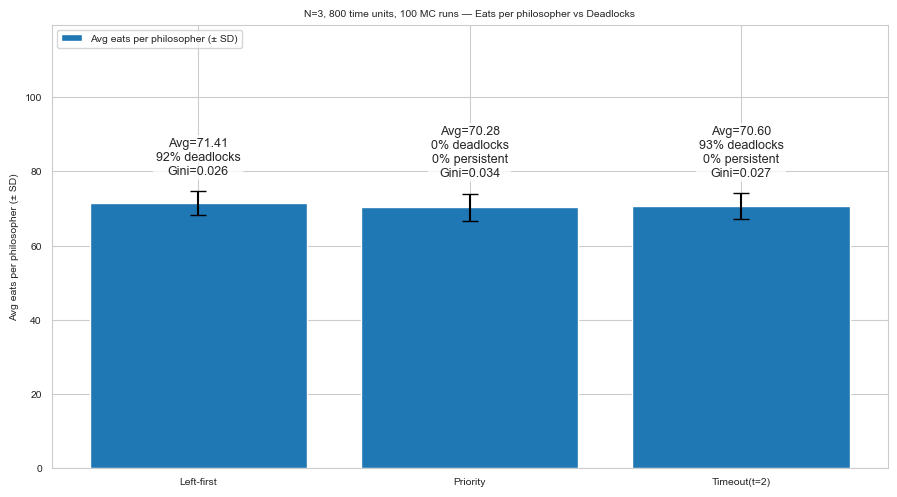

In [28]:

title = "N=3, 800 time units, 100 MC runs — Eats per philosopher vs Deadlocks"

plot_strategy_avg_eats_with_deadlock_text(
    dfs=dfs_3,
    labels=labels_3,
    title=title,
    annotate_gini=True,
)

plt.show()

Okay so with 3 phils, we see that we got a lot more deadlocks. So, it apparently is much more likely in this case that we have the deadlock conditions to get true

So I think for this reason, I will rather look at 5 philosophers, to ensure that deadlock chances are higher

## Variability in thinking time

In [29]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(num_philosophers=NUM_PHILS, deadlock_detection=True)

THINK_2_30 = dict(unif_thinking_time=True, think_unif_low=2.0, think_unif_high=30.0)
THINK_2_4  = dict(unif_thinking_time=True, think_unif_low=2.0, think_unif_high=4.0)

# Left-first, think U(2,30)
mc_lf_5 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none"), THINK_2_30),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Priority, think U(2,30)
mc_lf_5_4 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority"), THINK_2_30),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Left-first, think U(2,4)
mc_lf_5_2 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="none"), THINK_2_4),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

# Priority, think U(2,4)
mc_lf_5_3 = run_and_summarize(
    merge_cfg(BASE, dict(prevention_strategy="priority"), THINK_2_4),
    runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED,
    title_prefix="Randomized (MC)"
)

=== Randomized (MC) - Left-First - Think U(2.0,30.0) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 194.42 ± 7.29
Avg eats/philosopher: 38.88 ± 1.46
Avg min/max eats: 35.93 / 41.97
Avg Gini (fairness): 0.030
Deadlock runs: 0/100
Per-philosopher avg eats: [38.83, 38.84, 39.03, 38.91, 38.81]
Per-philosopher std eats: [2.55, 2.86, 3.07, 2.9, 2.49]
Per-philosopher avg thinking time: [621.28, 621.07, 619.15, 621.9, 621.77]
Per-philosopher avg hungry time:   [61.82, 62.59, 63.31, 60.17, 63.67]
Per-philosopher avg eating time:   [116.91, 116.33, 117.54, 117.94, 114.56]
Per-philosopher std thinking time: [22.95, 23.64, 24.56, 24.51, 24.56]
Per-philosopher std hungry time:   [16.61, 18.12, 18.66, 16.47, 18.02]
Per-philosopher std eating time:   [18.83, 18.15, 17.87, 18.68, 15.06]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Randomized (MC) - Priority - Think U(2.0,30.0) - Eat Exp(mean=3) (Detailed) ===
Runs: 100
Avg total eats: 193.66 ± 7.56
Avg eats/philosopher: 38.

we see the impact of the thinking time. if the thinking time duration is higher, then the deadlock chances are lower. i will also change the distribution for the eating times.

we also see here, the inequality in the priority increases with the number of philosophers / changing times

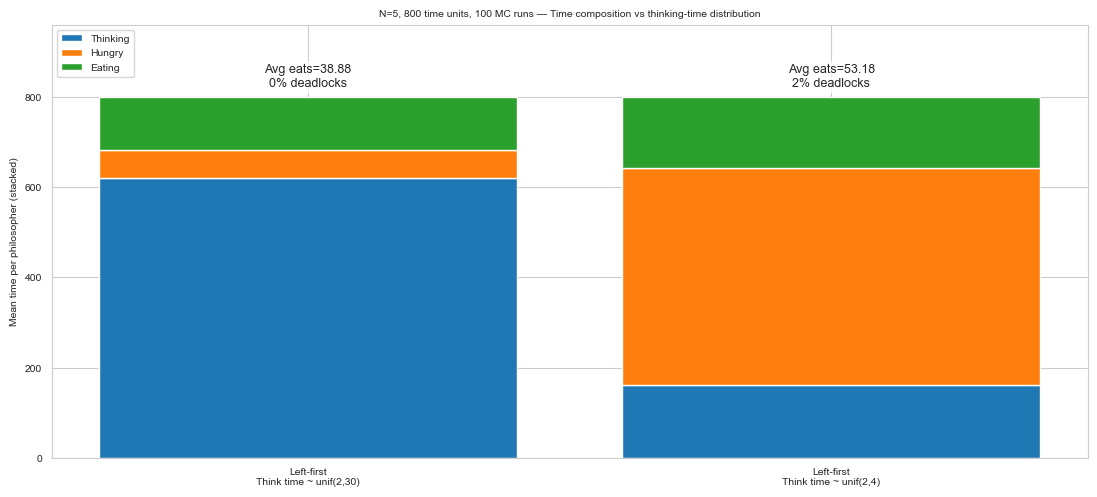

In [30]:
import numpy as np
import matplotlib.pyplot as plt


def _mean_over_runs_and_phils(list_col):
    """
    list_col: Series of lists with shape (num_phils,) per row.
    Returns scalar mean over all runs and philosophers.
    """
    arr = np.array(list_col.to_list(), dtype=float)  # shape: (runs, num_phils)
    return float(arr.mean())


def compare_thinking_time_cases_stacked(
    cases,
    title=None,
):
    """
    cases: list of dicts with keys:
      - "label": str
      - "df": pandas.DataFrame (output of run_monte_carlo_detailed)
    Produces a stacked bar plot of mean time composition (thinking/hungry/eating),
    with annotations for deadlock rate and avg eats per philosopher.
    """
    labels = [c["label"] for c in cases]
    dfs = [c["df"] for c in cases]
    x = np.arange(len(cases))

    mean_thinking = []
    mean_hungry = []
    mean_eating = []
    deadlock_rate = []
    mean_avg_eats = []

    for df in dfs:
        mean_thinking.append(_mean_over_runs_and_phils(df["thinking_times"]))
        mean_hungry.append(_mean_over_runs_and_phils(df["hungry_times"]))
        mean_eating.append(_mean_over_runs_and_phils(df["eating_times"]))

        deadlock_rate.append(100.0 * (df["deadlocks"] > 0).mean())
        mean_avg_eats.append(float(df["avg_eats"].mean()))

    fig, ax = plt.subplots(figsize=(11, 5))

    # Stacked bars (default matplotlib colors)
    b1 = ax.bar(x, mean_thinking, label="Thinking")
    b2 = ax.bar(x, mean_hungry, bottom=mean_thinking, label="Hungry")
    bottom_12 = np.array(mean_thinking) + np.array(mean_hungry)
    b3 = ax.bar(x, mean_eating, bottom=bottom_12, label="Eating")

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel("Mean time per philosopher (stacked)")
    if title:
        ax.set_title(title)

    ax.legend(loc="upper left")

    # Headroom for annotations
    total_time = bottom_12 + np.array(mean_eating)
    ax.set_ylim(0, float(total_time.max()) * 1.20)

    # Annotations: eats/philosopher and deadlock rate
    for i in range(len(cases)):
        txt = f"Avg eats={mean_avg_eats[i]:.2f}\n{deadlock_rate[i]:.0f}% deadlocks"
        ax.text(
            x[i],
            total_time[i] + float(total_time.max()) * 0.02,
            txt,
            ha="center",
            va="bottom",
            fontsize=9,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=2.0),
        )

    fig.tight_layout()
    return fig, ax


# --- Example call with your 4 dataframes ---
cases = [
    {"label": "Left-first\nThink time ~ unif(2,30)", "df": mc_lf_5},
    {"label": "Left-first\nThink time ~ unif(2,4)", "df": mc_lf_5_2},
]

compare_thinking_time_cases_stacked(
    cases,
    title="N=5, 800 time units, 100 MC runs — Time composition vs thinking-time distribution",
)

plt.show()


## Variability in eating time

Conclusion:

Setting thinking_time~unif(2,4) is just too much time for thinking. in this case, we have nearly 0 deadlock cases, so not that interesting. 

For this reason, I set thinking_time~unif(0.3,3), eating_time i will maybe alternate.

In [31]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000
TIMEOUT_DURATION = 2

BASE = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
)

THINKING = {
    "unif_2_30": dict(unif_thinking_time=True, think_unif_low=2.0, think_unif_high=30.0),
    "unif_0_3_3": dict(unif_thinking_time=True, think_unif_low=0.3, think_unif_high=3.0),
}

EATING = {
    "gauss_8_3_1_16": dict(gauss_eating_time=True, eat_mean=8.0, eat_sigma=3.0, eat_gauss_low=1.0, eat_gauss_high=16.0),
    "gauss_15_3_1_30": dict(gauss_eating_time=True, eat_mean=15.0, eat_sigma=3.0, eat_gauss_low=1.0, eat_gauss_high=30.0),
}

STRATEGY = {
    "left_first": dict(prevention_strategy="none"),
    "priority": dict(prevention_strategy="priority"),
    "timeout": dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION),
}

# looking at gauss_8_3_1_16 

mc_gauss_8_3_1_16_lf  = run_and_summarize(merge_cfg(BASE, STRATEGY["left_first"], THINKING["unif_0_3_3"], EATING["gauss_8_3_1_16"]))
mc_gauss_8_3_1_16_po = run_and_summarize(merge_cfg(BASE, STRATEGY["priority"],   THINKING["unif_0_3_3"], EATING["gauss_8_3_1_16"]))
TIMEOUT_DURATION = 8
STRATEGY["timeout"] = dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)
mc_gauss_8_3_1_16_to = run_and_summarize(merge_cfg(BASE, STRATEGY["timeout"],   THINKING["unif_0_3_3"], EATING["gauss_8_3_1_16"]))

# looking at gauss_15_3_1_30

mc_gauss_15_3_1_30_lf = run_and_summarize(merge_cfg(BASE, STRATEGY["left_first"], THINKING["unif_0_3_3"], EATING["gauss_15_3_1_30"]))
mc_gauss_15_3_1_30_po = run_and_summarize(merge_cfg(BASE, STRATEGY["priority"],   THINKING["unif_0_3_3"], EATING["gauss_15_3_1_30"]))
TIMEOUT_DURATION = 15
STRATEGY["timeout"] = dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)
mc_gauss_15_3_1_30_to = run_and_summarize(merge_cfg(BASE, STRATEGY["timeout"],   THINKING["unif_0_3_3"], EATING["gauss_15_3_1_30"]))


=== Left-First - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 99.48 ± 4.09
Avg eats/philosopher: 19.90 ± 0.82
Avg min/max eats: 19.37 / 20.38
Avg Gini (fairness): 0.010
Deadlock runs: 36/100
Avg first deadlock time: 377.01
Per-philosopher avg eats: [19.98, 19.82, 19.82, 19.92, 19.94]
Per-philosopher std eats: [0.95, 0.88, 0.92, 0.95, 0.98]
Per-philosopher avg thinking time: [34.48, 34.03, 33.7, 34.44, 34.43]
Per-philosopher avg hungry time:   [606.67, 607.08, 609.44, 605.18, 604.92]
Per-philosopher avg eating time:   [158.85, 158.9, 156.87, 160.39, 160.65]
Per-philosopher std thinking time: [3.64, 3.73, 4.0, 3.61, 4.04]
Per-philosopher std hungry time:   [12.15, 13.67, 15.15, 11.77, 14.35]
Per-philosopher std eating time:   [11.63, 13.56, 13.38, 10.76, 13.33]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72

the results seem legit, except for the thing with the deadlocks with the timeout strategy: gpt says, normyll with the timeout stratefy, we expect 0 deadlocks, but maybe it is beacuse of our implementation, where the deadlock just occurs for a short while, and then gets solved by the timeout strategy, but is still counted. 

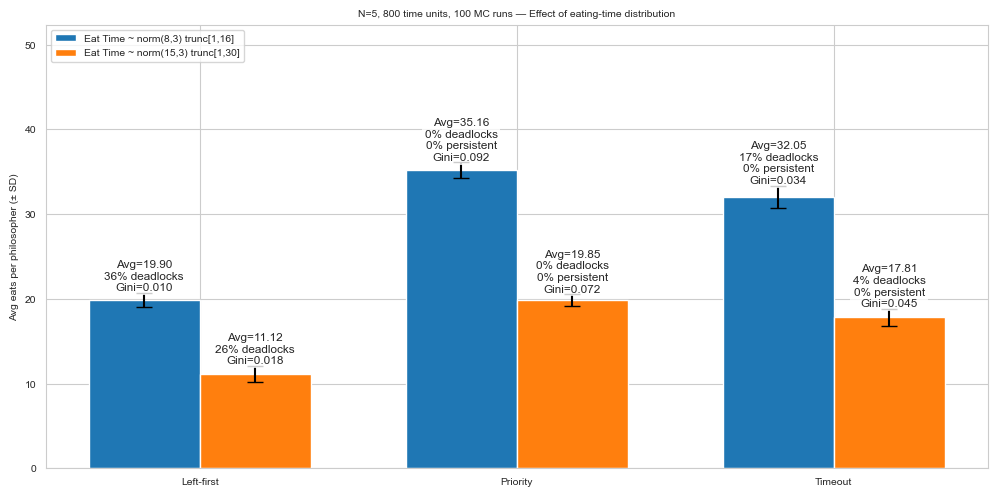

In [32]:
import numpy as np
import matplotlib.pyplot as plt


def plot_grouped_eats_with_deadlock_text(
    dfs_by_strategy,
    strategies,
    conditions,
    condition_labels=None,
    title=None,
    annotate_gini=True,
    annotate_persistent=True,
):
    """
    Grouped bar plot:
      - x-axis: strategies
      - bars per group: conditions (e.g., Eat N(8,3) vs Eat N(15,3))
      - y-axis: mean(avg_eats) with error bars (± SD across MC runs)
      - annotation per bar: Avg, deadlock rate, persistent-deadlock rate (if available), optional Gini
    """
    if condition_labels is None:
        condition_labels = conditions
    if len(condition_labels) != len(conditions):
        raise ValueError("condition_labels must have same length as conditions")

    # Aggregate stats
    mean_avg = {s: [] for s in strategies}
    std_avg = {s: [] for s in strategies}
    deadlock_pct = {s: [] for s in strategies}
    persistent_pct = {s: [] for s in strategies}
    gini_mean = {s: [] for s in strategies}

    for s in strategies:
        for c in conditions:
            df = dfs_by_strategy[s][c]

            mean_avg[s].append(float(df["avg_eats"].mean()))
            std_avg[s].append(float(df["avg_eats"].std(ddof=1)))
            deadlock_pct[s].append(100.0 * float((df["deadlocks"] > 0).mean()))
            gini_mean[s].append(float(df["gini_eats"].mean()))

            if annotate_persistent and ("persistent_deadlocks" in df.columns):
                persistent_pct[s].append(100.0 * float((df["persistent_deadlocks"] > 0).mean()))
            else:
                persistent_pct[s].append(None)

    # Layout
    x = np.arange(len(strategies))
    width = 0.35 if len(conditions) == 2 else min(0.8 / len(conditions), 0.25)
    offsets = (np.arange(len(conditions)) - (len(conditions) - 1) / 2) * width

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot bars per condition
    all_bar_tops = []
    for j, (c, clabel) in enumerate(zip(conditions, condition_labels)):
        y = [mean_avg[s][j] for s in strategies]
        yerr = [std_avg[s][j] for s in strategies]

        bars = ax.bar(x + offsets[j], y, width=width, yerr=yerr, capsize=6, label=clabel)

        # Per-bar annotations
        for i, rect in enumerate(bars):
            s = strategies[i]
            avg = mean_avg[s][j]
            sd = std_avg[s][j]
            dl = deadlock_pct[s][j]
            pd = persistent_pct[s][j]
            g = gini_mean[s][j]

            lines = [
                f"Avg={avg:.2f}",
                f"{dl:.0f}% deadlocks",
            ]

            if annotate_persistent and (pd is not None):
                lines.append(f"{pd:.0f}% persistent")

            if annotate_gini:
                lines.append(f"Gini={g:.3f}")

            ax.text(
                rect.get_x() + rect.get_width() / 2.0,
                avg + sd + 0.02,
                "\n".join(lines),
                ha="center",
                va="bottom",
                fontsize=8.5,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.8),
            )

            all_bar_tops.append(avg + sd)

    ax.set_xticks(x)
    ax.set_xticklabels(strategies)
    ax.set_ylabel("Avg eats per philosopher (± SD)")
    ax.legend(loc="upper left")

    if title:
        ax.set_title(title)

    y_top = max(all_bar_tops) if all_bar_tops else 1.0
    ax.set_ylim(0, y_top * 1.45)

    fig.tight_layout()
    return fig, ax
# ---------------- Example wiring (replace DF names with yours) ----------------
# Eat condition keys
cond_8 = "eat_mu_8"
cond_15 = "eat_mu_15"

dfs_by_strategy = {
    "Left-first": {
        cond_8:  mc_gauss_8_3_1_16_lf,    # <-- replace with your DF for Left-first, N(8,3)
        cond_15: mc_gauss_15_3_1_30_lf,   # <-- replace with your DF for Left-first, N(15,3)
    },
    "Priority": {
        cond_8:  mc_gauss_8_3_1_16_po,    # <-- replace with your DF for Priority, N(8,3)
        cond_15: mc_gauss_15_3_1_30_po,   # <-- replace with your DF for Priority, N(15,3)
    },
    "Timeout": {
        cond_8:  mc_gauss_8_3_1_16_to,    # <-- replace with your DF for Timeout, N(8,3)
        cond_15: mc_gauss_15_3_1_30_to,   # <-- replace with your DF for Timeout, N(15,3)
    },
}

strategies = ["Left-first", "Priority", "Timeout"]
conditions = [cond_8, cond_15]
condition_labels = ["Eat Time ~ norm(8,3) trunc[1,16]", "Eat Time ~ norm(15,3) trunc[1,30]"]

title = "N=5, 800 time units, 100 MC runs — Effect of eating-time distribution"

plot_grouped_eats_with_deadlock_text(
    dfs_by_strategy=dfs_by_strategy,
    strategies=strategies,
    conditions=conditions,
    condition_labels=condition_labels,
    title=title,
    annotate_gini=True,
)

plt.show()


## Selfish Philosophers

- Ideas for Selfish philosophers:
    - Ignores timeout and still holds chopsticks
    - Ignores priority ordering -> just takes left or right chopstick first randomly
    - Does not drop chopsticks directly after eating

I will just use the following base configs of the model:

- 5 Philosophers, Max_time = 800, MC runs = 100
- thinking time: unif(0.3, 3)
- eating time: norm(8, 3) (truncated: [1, 16]) 
- prevention strategy: lower chopstick id or timeout, will depend on actual case (f.e. ignoring timeout just possible for timeout strategy)

### Baseline for lower chopstick id strategy

In [33]:
MAX_TIME = 800
MC_RUNS = 100
NUM_PHILS = 5
SEED = 9000

BASE_COMMON = dict(
    num_philosophers=NUM_PHILS,
    deadlock_detection=True,
    halt_on_deadlock = True,

    # thinking: U(0.3, 3)
    unif_thinking_time=True,
    think_unif_low=0.3,
    think_unif_high=3.0,

    # eating: N(8,3) truncated to [1,16]
    gauss_eating_time=True,
    eat_mean=8.0,
    eat_sigma=3.0,
    eat_gauss_low=1.0,
    eat_gauss_high=16.0,
)

# Baseline 1: Priority (lower ID first)
cfg_priority = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="priority")
)
df_priority = run_and_summarize(cfg_priority, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")


=== Baseline - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72
Avg eats/philosopher: 35.16 ± 0.94
Avg min/max eats: 29.17 / 45.66
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [29.46, 33.61, 37.47, 45.66, 29.6]
Per-philosopher std eats: [1.75, 1.34, 1.47, 2.51, 1.67]
Per-philosopher avg thinking time: [49.92, 56.12, 62.89, 76.11, 50.15]
Per-philosopher avg hungry time:   [515.05, 474.82, 435.67, 359.34, 510.37]
Per-philosopher avg eating time:   [235.02, 269.05, 301.45, 364.55, 239.49]
Per-philosopher std thinking time: [5.5, 4.53, 5.2, 6.08, 5.35]
Per-philosopher std hungry time:   [20.17, 17.77, 19.5, 19.49, 21.8]
Per-philosopher std eating time:   [17.31, 16.44, 17.8, 18.04, 19.59]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



### Baseline for timeout strategy

In [34]:
TIMEOUT_DURATION = 8  # aligned with eat_mean=8

# Baseline 2: Timeout
cfg_timeout = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="timeout", timeout_duration=TIMEOUT_DURATION)
)
df_timeout = run_and_summarize(cfg_timeout, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

=== Baseline - Timeout(t=8) - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 160.24 ± 6.62
Avg eats/philosopher: 32.05 ± 1.32
Avg min/max eats: 29.29 / 34.76
Avg Gini (fairness): 0.034
Deadlock runs: 17/100
Avg first deadlock time: 397.93
Avg timeout releases/run: 80.67 ± 9.41
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.03, 31.94, 32.11, 31.88, 32.28]
Per-philosopher std eats: [2.33, 2.5, 2.61, 2.47, 2.69]
Per-philosopher avg thinking time: [53.75, 54.27, 54.29, 52.86, 53.92]
Per-philosopher avg hungry time:   [490.21, 491.34, 485.71, 494.37, 485.32]
Per-philosopher avg eating time:   [256.04, 254.4, 260.0, 252.77, 260.76]
Per-philosopher std thinking time: [5.97, 6.42, 6.01, 6.17, 6.36]
Per-philosopher std hungry time:   [25.49, 26.13, 24.5, 25.6, 28.94]
Per-philosopher std eating time:   [22.12, 22.67, 21.62, 22.34, 24.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



### 1 Selfish Philosopher: Ignoring timeout + Not dropping after eating

Selfish Philosopher does the following:
- Ignores timeout and still holds chopsticks
- Does not drop chopsticks directly after eating

In [35]:
TIMEOUT_DURATION = 8 

# Again printing timeout baseline results:
df_timeout = run_and_summarize(cfg_timeout, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# 1 selfish philosopher 
cfg_selfish_1 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="timeout",
        timeout_duration=TIMEOUT_DURATION,
        selfish_ids={3},            
    )
)

df_selfish_1 = run_and_summarize(cfg_selfish_1, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="1 Selfish Philosopher")

=== Baseline - Timeout(t=8) - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 160.24 ± 6.62
Avg eats/philosopher: 32.05 ± 1.32
Avg min/max eats: 29.29 / 34.76
Avg Gini (fairness): 0.034
Deadlock runs: 17/100
Avg first deadlock time: 397.93
Avg timeout releases/run: 80.67 ± 9.41
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.03, 31.94, 32.11, 31.88, 32.28]
Per-philosopher std eats: [2.33, 2.5, 2.61, 2.47, 2.69]
Per-philosopher avg thinking time: [53.75, 54.27, 54.29, 52.86, 53.92]
Per-philosopher avg hungry time:   [490.21, 491.34, 485.71, 494.37, 485.32]
Per-philosopher avg eating time:   [256.04, 254.4, 260.0, 252.77, 260.76]
Per-philosopher std thinking time: [5.97, 6.42, 6.01, 6.17, 6.36]
Per-philosopher std hungry time:   [25.49, 26.13, 24.5, 25.6, 28.94]
Per-philosopher std eating time:   [22.12, 22.67, 21.62, 22.34, 24.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== 1 Selfish Philosopher - Timeout(t=8)

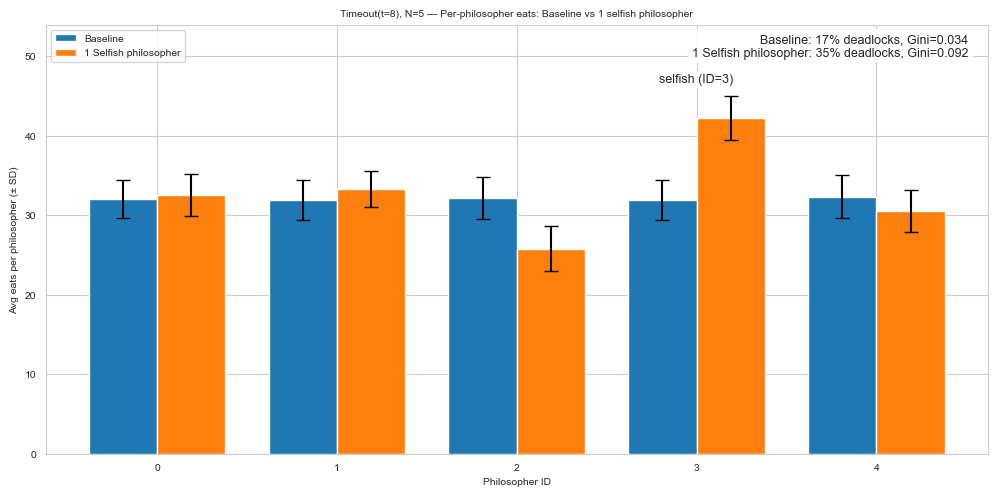

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def _per_philo_mean_std_from_counts(df):
    """
    df["eat_counts"] contains lists of length num_philosophers per run.
    Returns arrays: mean_per_philo, std_per_philo across runs.
    """
    eats = np.array(df["eat_counts"].to_list(), dtype=float)  # (runs, num_phils)
    return eats.mean(axis=0), eats.std(axis=0, ddof=1)


def plot_per_philosopher_eats_baseline_vs_selfish(
    df_baseline,
    df_selfish,
    selfish_id,
    title=None,
    baseline_label="Baseline",
    selfish_label="1 Selfish philosopher",
):
    mean_b, std_b = _per_philo_mean_std_from_counts(df_baseline)
    mean_s, std_s = _per_philo_mean_std_from_counts(df_selfish)

    n = len(mean_b)
    x = np.arange(n)
    width = 0.38

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(
        x - width / 2,
        mean_b,
        width,
        yerr=std_b,
        capsize=5,
        label=baseline_label,
    )
    ax.bar(
        x + width / 2,
        mean_s,
        width,
        yerr=std_s,
        capsize=5,
        label=selfish_label,
    )

    ax.set_xlabel("Philosopher ID")
    ax.set_ylabel("Avg eats per philosopher (± SD)")
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.legend(loc="upper left")

    if title:
        ax.set_title(title)

    ax.text(
        selfish_id,
        max((mean_b + std_b).max(), (mean_s + std_s).max()) * 1.03,
        f"selfish (ID={selfish_id})",
        ha="center",
        va="bottom",
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=2.0),
    )

    dead_b = 100.0 * float((df_baseline["deadlocks"] > 0).mean())
    dead_s = 100.0 * float((df_selfish["deadlocks"] > 0).mean())
    gini_b = float(df_baseline["gini_eats"].mean())
    gini_s = float(df_selfish["gini_eats"].mean())

    summary = (
        f"{baseline_label}: {dead_b:.0f}% deadlocks, Gini={gini_b:.3f}\n"
        f"{selfish_label}: {dead_s:.0f}% deadlocks, Gini={gini_s:.3f}"
    )
    ax.text(
        0.98,
        0.98,
        summary,
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=3.0),
    )

    y_top = max((mean_b + std_b).max(), (mean_s + std_s).max())
    ax.set_ylim(0, float(y_top) * 1.20)

    fig.tight_layout()
    return fig, ax



# Call
plot_per_philosopher_eats_baseline_vs_selfish(
    df_baseline=df_timeout,
    df_selfish=df_selfish_1,
    selfish_id=3,
    title="Timeout(t=8), N=5 — Per-philosopher eats: Baseline vs 1 selfish philosopher",
)

plt.show()


### 2 Selfish Philosophers: Ignoring timeout + Not dropping after eating

They do the same as in the case with 1 selfish philoopher

In [37]:
TIMEOUT_DURATION = 8 

# Again printing timeout baseline results:
df_timeout = run_and_summarize(cfg_timeout, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# 2 selfish philosophers 
cfg_selfish_2 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="timeout",
        timeout_duration=TIMEOUT_DURATION,
        selfish_ids={0,2},            
    )
)

df_selfish_2 = run_and_summarize(cfg_selfish_2, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="2 Selfish Philosophers")

=== Baseline - Timeout(t=8) - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 160.24 ± 6.62
Avg eats/philosopher: 32.05 ± 1.32
Avg min/max eats: 29.29 / 34.76
Avg Gini (fairness): 0.034
Deadlock runs: 17/100
Avg first deadlock time: 397.93
Avg timeout releases/run: 80.67 ± 9.41
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.03, 31.94, 32.11, 31.88, 32.28]
Per-philosopher std eats: [2.33, 2.5, 2.61, 2.47, 2.69]
Per-philosopher avg thinking time: [53.75, 54.27, 54.29, 52.86, 53.92]
Per-philosopher avg hungry time:   [490.21, 491.34, 485.71, 494.37, 485.32]
Per-philosopher avg eating time:   [256.04, 254.4, 260.0, 252.77, 260.76]
Per-philosopher std thinking time: [5.97, 6.42, 6.01, 6.17, 6.36]
Per-philosopher std hungry time:   [25.49, 26.13, 24.5, 25.6, 28.94]
Per-philosopher std eating time:   [22.12, 22.67, 21.62, 22.34, 24.86]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== 2 Selfish Philosophers - Timeout(t=8

### 1 Selfish Philosopher: Ignoring priority ordering + Not dropping after eating

Selfish Philosopher does the following:
- Ignores timeout and still holds chopstick
- Does not drop chopsticks immediately after eating

In [38]:
# Baseline 1: Priority (lower ID first)
cfg_priority = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="priority")
)

df_priority = run_and_summarize(cfg_priority, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

# selfish
cfg_selfish_3 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="priority",
        selfish_ids={1})
)
df_selfish_3 = run_and_summarize(cfg_selfish_3, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="1 Selfish Philosopher")

=== Baseline - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72
Avg eats/philosopher: 35.16 ± 0.94
Avg min/max eats: 29.17 / 45.66
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [29.46, 33.61, 37.47, 45.66, 29.6]
Per-philosopher std eats: [1.75, 1.34, 1.47, 2.51, 1.67]
Per-philosopher avg thinking time: [49.92, 56.12, 62.89, 76.11, 50.15]
Per-philosopher avg hungry time:   [515.05, 474.82, 435.67, 359.34, 510.37]
Per-philosopher avg eating time:   [235.02, 269.05, 301.45, 364.55, 239.49]
Per-philosopher std thinking time: [5.5, 4.53, 5.2, 6.08, 5.35]
Per-philosopher std hungry time:   [20.17, 17.77, 19.5, 19.49, 21.8]
Per-philosopher std eating time:   [17.31, 16.44, 17.8, 18.04, 19.59]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== 1 Selfish Philosopher - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100

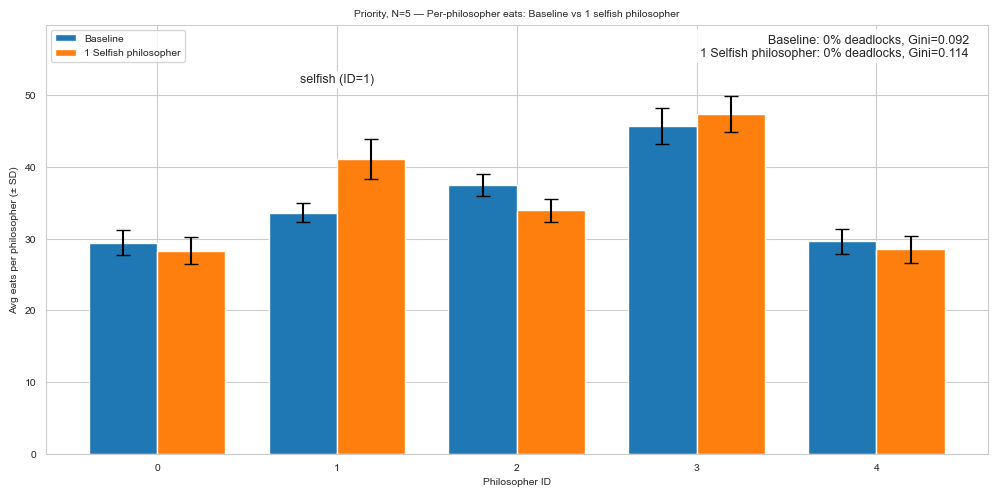

In [39]:


plot_per_philosopher_eats_baseline_vs_selfish(
    df_baseline=df_priority,
    df_selfish=df_selfish_3,
    selfish_id=1,
    title="Priority, N=5 — Per-philosopher eats: Baseline vs 1 selfish philosopher",
)
plt.show()


plt.show()


### 2 Selfish Philosophers: Ignoring priority ordering + Not dropping after eating
They do the same as in the case with 1 selfish philoopher

In [40]:
# selfish
cfg_selfish_4 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="priority",
        selfish_ids={0,3})
)
df_selfish_4 = run_and_summarize(cfg_selfish_4, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="2 Selfish Philosophers")

=== 2 Selfish Philosophers - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 179.02 ± 6.96
Avg eats/philosopher: 35.80 ± 1.39
Avg min/max eats: 26.14 / 53.83
Avg Gini (fairness): 0.148
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [32.64, 26.62, 38.58, 53.83, 27.35]
Per-philosopher std eats: [2.88, 1.68, 2.17, 2.93, 1.95]
Per-philosopher avg thinking time: [54.42, 45.1, 64.37, 88.87, 46.58]
Per-philosopher avg hungry time:   [483.94, 542.87, 428.3, 280.22, 537.39]
Per-philosopher avg eating time:   [261.64, 212.03, 307.33, 430.91, 216.02]
Per-philosopher std thinking time: [3.8, 4.59, 6.13, 4.28, 4.84]
Per-philosopher std hungry time:   [25.03, 16.87, 21.38, 23.81, 19.04]
Per-philosopher std eating time:   [23.66, 15.25, 19.28, 23.74, 16.99]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]



## Conspiracies

Idea: 

- 2 conspirator philosophers ry to starve a victim philosopher  by keeping the victim’s required chopsticks unavailable as often as possible.
- the conspiracy is active while the victim is hungry. Otherwise, the victims are acting normally.
- Targeted acquisition: When the victim is hungry, each conspirator prioritizes the victim-critical chopstick:
    - left neighbor of victim tries to acquire chopstick v
    - right neighbor of victim tries to acquire chopstick (v+1) mod N
- Targeted holding: After finishing eating, a conspirator performs a partial release:
    - it keeps holding only the victim-critical (target) chopstick
    - -> it holds the target chopstick for an additional time conspiracy_extra_hold to block the victim
- Conspirators retry faster when the victim is hungry (retry_time reduced to conspiracy_retry_fast)
- The victim retries slower when hungry (retry_time increased to a minimum threshold), reducing the victim’s chances to catch short “free” windows (like f.e the other philosophers block him in real life)

In [41]:
# Baseline 1: Priority (lower ID first)
cfg_priority = merge_cfg(
    BASE_COMMON,
    dict(prevention_strategy="priority")
)

df_priority = run_and_summarize(cfg_priority, runs=MC_RUNS, max_time=MAX_TIME, base_seed=SEED, title_prefix="Baseline")

cfg_conspiracy_02_block_1 = merge_cfg(
    BASE_COMMON,
    dict(
        prevention_strategy="priority",          
        conspiracy_ids={1, 3},
        conspiracy_victim=2,
        conspiracy_extra_hold=3,      
        conspiracy_retry_fast=0.1      
    )
)

df_conspiracy_02_block_1 = run_and_summarize(
    cfg_conspiracy_02_block_1,
    runs=MC_RUNS,
    max_time=MAX_TIME,
    base_seed=SEED,
    title_prefix="Conspiracy (1,3) blocks 2"
)


=== Baseline - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs: 100
Avg total eats: 175.80 ± 4.72
Avg eats/philosopher: 35.16 ± 0.94
Avg min/max eats: 29.17 / 45.66
Avg Gini (fairness): 0.092
Deadlock runs: 0/100
Persistent-deadlock runs: 0/100
Per-philosopher avg eats: [29.46, 33.61, 37.47, 45.66, 29.6]
Per-philosopher std eats: [1.75, 1.34, 1.47, 2.51, 1.67]
Per-philosopher avg thinking time: [49.92, 56.12, 62.89, 76.11, 50.15]
Per-philosopher avg hungry time:   [515.05, 474.82, 435.67, 359.34, 510.37]
Per-philosopher avg eating time:   [235.02, 269.05, 301.45, 364.55, 239.49]
Per-philosopher std thinking time: [5.5, 4.53, 5.2, 6.08, 5.35]
Per-philosopher std hungry time:   [20.17, 17.77, 19.5, 19.49, 21.8]
Per-philosopher std eating time:   [17.31, 16.44, 17.8, 18.04, 19.59]
Zero-eat rate by philosopher: [0.0, 0.0, 0.0, 0.0, 0.0]

=== Conspiracy (1,3) blocks 2 - Priority - Think U(0.3,3.0) - Eat N(8.0,3.0) truncated[1.0,16.0] (Detailed) ===
Runs:

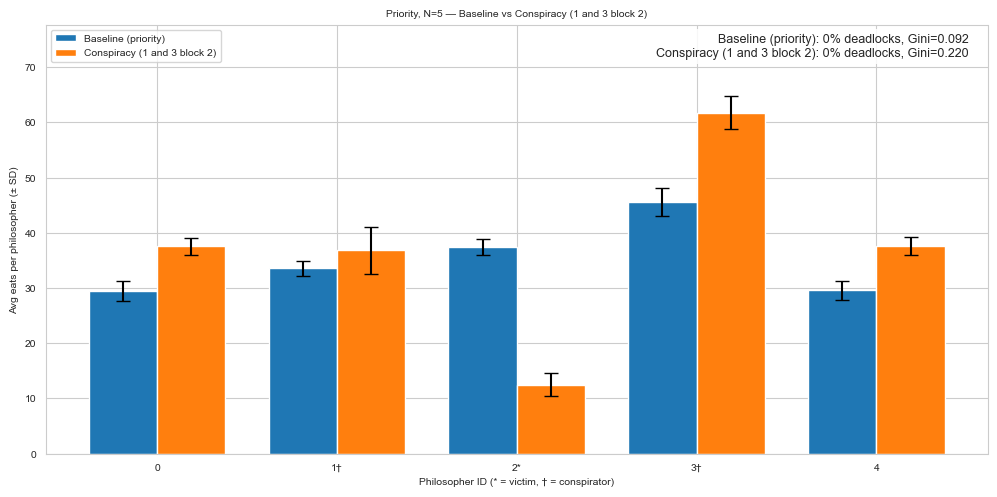

In [42]:
def _per_philo_mean_std_from_counts(df):
    eats = np.array(df["eat_counts"].to_list(), dtype=float)
    return eats.mean(axis=0), eats.std(axis=0, ddof=1)


def plot_per_philosopher_baseline_vs_case(
    df_baseline,
    df_case,
    title=None,
    baseline_label="Baseline",
    case_label="Case",
    victim_id=None,
    conspirator_ids=None,
):
    conspirator_ids = set(conspirator_ids or [])

    mean_b, std_b = _per_philo_mean_std_from_counts(df_baseline)
    mean_c, std_c = _per_philo_mean_std_from_counts(df_case)

    n = len(mean_b)
    x = np.arange(n)
    width = 0.38

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(x - width/2, mean_b, width, yerr=std_b, capsize=5, label=baseline_label)
    ax.bar(x + width/2, mean_c, width, yerr=std_c, capsize=5, label=case_label)

    # Marked tick labels
    tick_labels = []
    for i in range(n):
        suffix = ""
        if victim_id is not None and i == victim_id:
            suffix += "*"   # victim
        if i in conspirator_ids:
            suffix += "†"   # conspirator
        tick_labels.append(f"{i}{suffix}")

    ax.set_xticks(x)
    ax.set_xticklabels(tick_labels)
    ax.set_xlabel("Philosopher ID (* = victim, † = conspirator)")
    ax.set_ylabel("Avg eats per philosopher (± SD)")
    ax.legend(loc="upper left")

    if title:
        ax.set_title(title)

    # Summary box (top-right)
    dead_b = 100.0 * float((df_baseline["deadlocks"] > 0).mean())
    dead_c = 100.0 * float((df_case["deadlocks"] > 0).mean())
    gini_b = float(df_baseline["gini_eats"].mean())
    gini_c = float(df_case["gini_eats"].mean())

    summary = (
        f"{baseline_label}: {dead_b:.0f}% deadlocks, Gini={gini_b:.3f}\n"
        f"{case_label}: {dead_c:.0f}% deadlocks, Gini={gini_c:.3f}"
    )
    ax.text(
        0.98, 0.98, summary,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.85, pad=3.0),
    )

    y_top = max((mean_b + std_b).max(), (mean_c + std_c).max())
    ax.set_ylim(0, float(y_top) * 1.20)

    fig.tight_layout()
    return fig, ax


# Call for your case
plot_per_philosopher_baseline_vs_case(
    df_baseline=df_priority,
    df_case=df_conspiracy_02_block_1,
    title="Priority, N=5 — Baseline vs Conspiracy (1 and 3 block 2)",
    baseline_label="Baseline (priority)",
    case_label="Conspiracy (1 and 3 block 2)",
    victim_id=2,
    conspirator_ids={1, 3},
)

plt.show()
